In [21]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
from datetime import datetime
from datetime import timedelta
import os


In [22]:
state_names = ["US", "Alaska", "Alabama", "Arkansas", "Arizona", "California", "Colorado", "Connecticut", "District of Columbia", "Delaware", "Florida", "Georgia", "Guam", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Puerto Rico", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Virgin Islands", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]

In [23]:
# Create dictionary for FIPS code
url = 'https://raw.githubusercontent.com/reichlab/covid19-forecast-hub/master/data-locations/locations.csv'
df_fips = pd.read_csv(url, error_bad_lines=False)
us_state_fips = {}
for index, row in df_fips.iterrows():
    if index < 58 and index >= 0:
        us_state_fips[row["location_name"]] = row["location"]
us_state_fips

{'US': 'US',
 'Alabama': '01',
 'Alaska': '02',
 'Arizona': '04',
 'Arkansas': '05',
 'California': '06',
 'Colorado': '08',
 'Connecticut': '09',
 'Delaware': '10',
 'District of Columbia': '11',
 'Florida': '12',
 'Georgia': '13',
 'Hawaii': '15',
 'Idaho': '16',
 'Illinois': '17',
 'Indiana': '18',
 'Iowa': '19',
 'Kansas': '20',
 'Kentucky': '21',
 'Louisiana': '22',
 'Maine': '23',
 'Maryland': '24',
 'Massachusetts': '25',
 'Michigan': '26',
 'Minnesota': '27',
 'Mississippi': '28',
 'Missouri': '29',
 'Montana': '30',
 'Nebraska': '31',
 'Nevada': '32',
 'New Hampshire': '33',
 'New Jersey': '34',
 'New Mexico': '35',
 'New York': '36',
 'North Carolina': '37',
 'North Dakota': '38',
 'Ohio': '39',
 'Oklahoma': '40',
 'Oregon': '41',
 'Pennsylvania': '42',
 'Rhode Island': '44',
 'South Carolina': '45',
 'South Dakota': '46',
 'Tennessee': '47',
 'Texas': '48',
 'Utah': '49',
 'Vermont': '50',
 'Virginia': '51',
 'Washington': '53',
 'West Virginia': '54',
 'Wisconsin': '55',
 '

In [60]:
def plot_original(df, state):
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
    date = [datetime.strptime(d, '%Y-%m-%d').date() for d in df.columns]
    plt.plot(date,df.loc["Confirmed"],date,df.loc["Deaths"], date,df.loc["New_Confirmed"], date,df.loc["New_Deaths"])
    plt.legend(['Confirmed', 'Deaths', 'Inc Case', 'Inc Death'])
    plt.xlabel("Date")
    plt.ylabel("Cases")
    plt.title(state)
    plt.gcf().autofmt_xdate()
    
    
    outdir = './' + state
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    plt.savefig(os.path.join(outdir, state + "_original.png"))
    plt.show()

In [61]:
#ARIMA model
#One-day forecast
def evaluate_arima_model(X, arima_order):
    # Split dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    # Make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

#Grid search best parameters
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg

In [62]:
def grid_search(df):
    #Plot Autocorrelation
    pd.plotting.autocorrelation_plot(df)
    plt.show()

    #Grid search
    p_values = range(1, 10)
    d_values = range(0, 3)
    q_values = range(0, 3)
    warnings.filterwarnings("ignore")
    best_cfg = evaluate_models(df.values, p_values, d_values, q_values)
    return best_cfg

In [63]:
def prediction(df, state, date, category, best_cfg, pred):
    # Show best
    X = df.values
    size = int(len(X) * 0.66)
    train, test = X[0:size], X[size:len(X)]
    test_date = date[size:len(X)]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=best_cfg)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat[0])
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
    error = mean_squared_error(test, predictions)
    print('Test MSE: %.3f' % error)
    
    # Get 30-days extra prediction
    for t in range(30):
        model = ARIMA(history, order=best_cfg)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat[0])
        history.append(yhat[0])    
    
    # Plot
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
    test_date = [datetime.strptime(d, '%Y-%m-%d').date() for d in test_date]
    plt.plot(test_date, test)
    
    last = test_date[-1]
    for t in range(30):
        test_date.append(last + timedelta(days=t+1))
    plt.plot(test_date, predictions, color='red')
    plt.legend(['Original', 'Prediction'])
    plt.xlabel("Date")
    plt.ylabel("Cases")
    plt.title(state + ' ' + category)
    plt.gcf().autofmt_xdate()
    plt.savefig('./' + state + '/' + state + "_" + category + ".png")
    plt.show()
    

    forecast_date = [d - timedelta(days=1) for d in test_date]
    for i in range(len(forecast_date)):
        if forecast_date[i] > datetime.today().date():
            forecast_date[i] = datetime.today().date()
    df_new = pd.DataFrame(columns=["location","target","type","quantile","forecast_date","target_end_date","value"])
    df_new["forecast_date"] = forecast_date
    df_new["target_end_date"] = test_date
    df_new["location"] = us_state_fips[state]
    
    if category == "Confirmed":
        df_new["target"] = "1 day ahead cum case"
    elif category == "Deaths":
        df_new["target"] = "1 day ahead cum death"
    elif category == "New_Confirmed":
        df_new["target"] = "1 day ahead inc case"
    else:
        df_new["target"] = "1 day ahead inc death"
    
    df_new["type"] = "point"
    df_new["quantile"] = "NA"
    df_new["value"] = predictions
    if pred.empty:
        pred = df_new
    else:
        pred = pd.concat([pred,df_new],axis=0,ignore_index=True)
    return pred


In [64]:
def combined(state, df, best_df, pred):
    #df = read_data(state)
    plot_original(df, state)
    
    #Confirmed
    best_cfg1 = grid_search(df.loc["Confirmed"])
    pred = prediction(df.loc["Confirmed"], state, df.columns, "Confirmed", best_cfg1, pred)
    best_df.at[state,"Confirmed"] = best_cfg1
    
    #Deaths
    best_cfg2 = grid_search(df.loc["Deaths"])
    pred = prediction(df.loc["Deaths"], state, df.columns, "Deaths",best_cfg2, pred)
    best_df.at[state,"Deaths"] = best_cfg2
    
    #Inc case
    best_cfg3 = grid_search(df.loc["New_Confirmed"])
    pred = prediction(df.loc["New_Confirmed"], state, df.columns, "Inc Case", best_cfg3, pred)
    best_df.at[state,"Inc Case"] = best_cfg3
    
    #Inc death
    best_cfg4 = grid_search(df.loc["New_Deaths"])
    pred = prediction(df.loc["New_Deaths"], state, df.columns, "Inc Death",best_cfg4, pred)
    best_df.at[state,"Inc Death"] = best_cfg4
    
    return best_df, pred
    

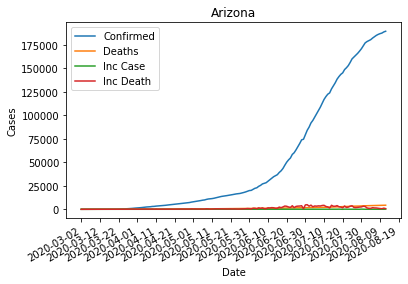

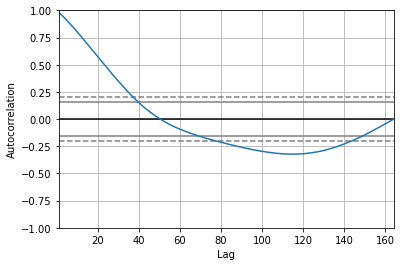

ARIMA(1, 0, 0) MSE=8324858.982
ARIMA(1, 1, 0) MSE=1311183.561
ARIMA(1, 2, 0) MSE=1215257.590
ARIMA(1, 2, 1) MSE=1001567.900
ARIMA(2, 1, 0) MSE=1220042.848
ARIMA(2, 2, 0) MSE=1118968.599
ARIMA(2, 2, 1) MSE=1070379.666
ARIMA(3, 1, 0) MSE=1124098.336
ARIMA(3, 2, 0) MSE=1127793.035
ARIMA(3, 2, 1) MSE=1124448.210
ARIMA(4, 1, 0) MSE=1137046.244
ARIMA(4, 2, 0) MSE=1096764.442
ARIMA(5, 1, 0) MSE=1098539.286
ARIMA(5, 2, 0) MSE=1154532.360
ARIMA(6, 1, 0) MSE=1150139.677
Best ARIMA(1, 2, 1) MSE=1001567.900
predicted=42626.678748, expected=43445.000000
predicted=45420.291706, expected=46910.000000
predicted=49740.946406, expected=50127.000000
predicted=53264.886842, expected=52591.000000
predicted=55303.626838, expected=54599.000000
predicted=56905.581088, expected=58378.000000
predicted=61461.029814, expected=60190.000000
predicted=62910.865909, expected=63281.000000
predicted=65977.569148, expected=66659.000000
predicted=69647.635335, expected=70124.000000
predicted=73344.962126, expected=73920.

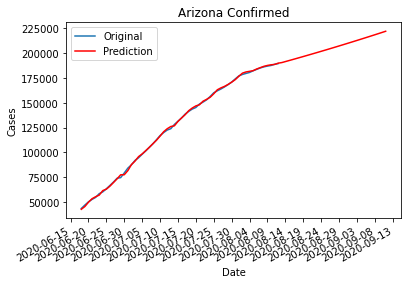

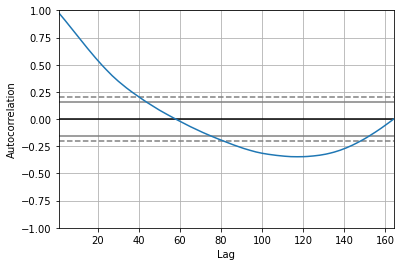

ARIMA(1, 0, 0) MSE=4772.117
ARIMA(1, 1, 0) MSE=2318.396
ARIMA(1, 2, 0) MSE=2495.402
ARIMA(2, 0, 0) MSE=2593.590
ARIMA(2, 1, 0) MSE=2275.742
ARIMA(2, 2, 0) MSE=2322.627
ARIMA(3, 0, 0) MSE=2419.114
ARIMA(3, 1, 0) MSE=2255.925
ARIMA(3, 2, 0) MSE=2274.272
ARIMA(4, 1, 0) MSE=2250.559
ARIMA(4, 2, 0) MSE=2195.966
ARIMA(4, 2, 1) MSE=1777.067
ARIMA(5, 1, 0) MSE=2225.567
ARIMA(5, 2, 0) MSE=2045.046
ARIMA(5, 2, 1) MSE=1674.547
ARIMA(6, 1, 0) MSE=2084.500
ARIMA(6, 2, 0) MSE=1359.945
ARIMA(6, 2, 1) MSE=1367.054
ARIMA(7, 1, 0) MSE=1375.582
ARIMA(7, 2, 0) MSE=1376.082
ARIMA(7, 2, 2) MSE=1361.979
ARIMA(8, 1, 0) MSE=1405.704
ARIMA(8, 2, 0) MSE=1427.985
ARIMA(9, 1, 0) MSE=1453.350
ARIMA(9, 2, 0) MSE=1453.139
Best ARIMA(6, 2, 0) MSE=1359.945
predicted=1278.415280, expected=1283.000000
predicted=1306.373905, expected=1321.000000
predicted=1348.726584, expected=1346.000000
predicted=1361.907001, expected=1349.000000
predicted=1364.526468, expected=1351.000000
predicted=1370.915043, expected=1396.000000
pre

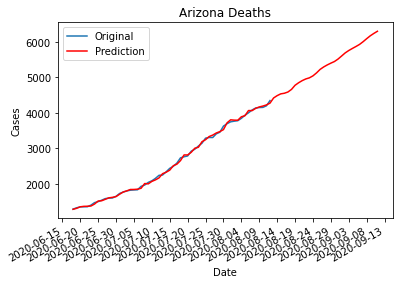

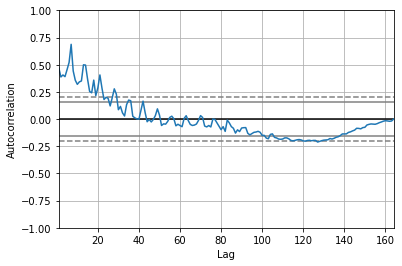

ARIMA(1, 0, 0) MSE=2320.770
ARIMA(1, 1, 0) MSE=2495.294
ARIMA(1, 2, 0) MSE=5027.033
ARIMA(2, 0, 0) MSE=2276.911
ARIMA(2, 1, 0) MSE=2322.544
ARIMA(2, 2, 0) MSE=3949.943
ARIMA(3, 0, 0) MSE=2256.295
ARIMA(3, 1, 0) MSE=2274.195
ARIMA(3, 2, 0) MSE=3767.500
ARIMA(4, 0, 0) MSE=2250.609
ARIMA(4, 1, 0) MSE=2195.931
ARIMA(4, 1, 1) MSE=1771.559
ARIMA(4, 2, 0) MSE=3676.390
ARIMA(5, 0, 0) MSE=2225.316
ARIMA(5, 1, 0) MSE=2045.060
ARIMA(5, 1, 1) MSE=1674.580
ARIMA(5, 1, 2) MSE=69758.431
ARIMA(5, 2, 0) MSE=3744.407
ARIMA(6, 0, 0) MSE=2080.194
ARIMA(6, 1, 0) MSE=1360.015
ARIMA(6, 1, 1) MSE=1367.145
ARIMA(6, 1, 2) MSE=1488.664
ARIMA(6, 2, 0) MSE=2414.511
ARIMA(7, 0, 0) MSE=1377.529
ARIMA(7, 1, 0) MSE=1376.202
ARIMA(7, 1, 2) MSE=1362.228
ARIMA(7, 2, 0) MSE=2008.649
ARIMA(8, 0, 0) MSE=1399.398
ARIMA(8, 1, 0) MSE=1428.128
ARIMA(8, 1, 2) MSE=1431.512
ARIMA(9, 0, 0) MSE=1457.390
ARIMA(9, 1, 0) MSE=1453.031
Best ARIMA(6, 1, 0) MSE=1360.015
predicted=29.408933, expected=34.000000
predicted=23.363518, expected=

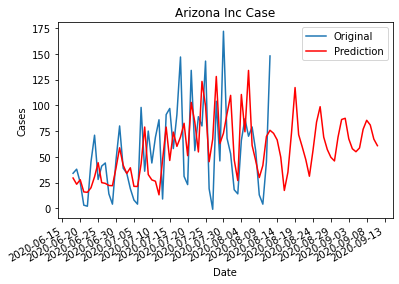

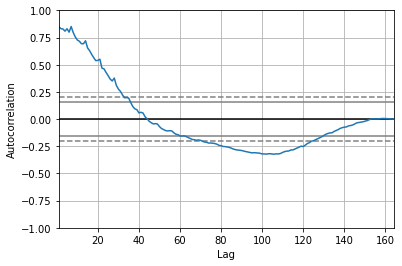

ARIMA(1, 0, 0) MSE=1311464.817
ARIMA(1, 1, 0) MSE=1215239.817
ARIMA(1, 1, 1) MSE=1001520.977
ARIMA(1, 2, 0) MSE=2549981.234
ARIMA(2, 0, 0) MSE=1216055.874
ARIMA(2, 1, 0) MSE=1118962.816
ARIMA(2, 1, 1) MSE=1070224.957
ARIMA(2, 2, 0) MSE=1955859.844
ARIMA(3, 0, 0) MSE=1121601.099
ARIMA(3, 1, 0) MSE=1127808.995
ARIMA(3, 1, 1) MSE=1124616.282
ARIMA(3, 2, 0) MSE=1892213.066
ARIMA(4, 0, 0) MSE=1917838.726
ARIMA(4, 1, 0) MSE=1096796.382
ARIMA(5, 0, 0) MSE=1098212.600
ARIMA(5, 1, 0) MSE=1154592.106
ARIMA(6, 0, 0) MSE=1152656.104
Best ARIMA(1, 1, 1) MSE=1001520.977
predicted=1689.600251, expected=2508.000000
predicted=1975.450391, expected=3465.000000
predicted=2831.300283, expected=3217.000000
predicted=3137.963036, expected=2464.000000
predicted=2712.482978, expected=2008.000000
predicted=2306.250053, expected=3779.000000
predicted=3082.805888, expected=1812.000000
predicted=2720.333706, expected=3091.000000
predicted=2695.791451, expected=3378.000000
predicted=2988.282761, expected=3465.0000

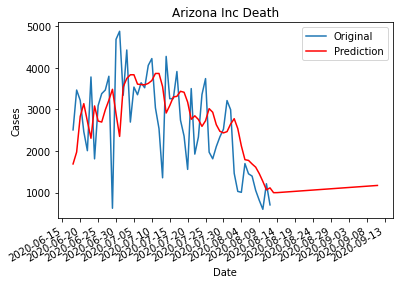

                      Confirmed     Deaths   Inc Case  Inc Death
US                          NaN        NaN        NaN        NaN
Alaska                      NaN        NaN        NaN        NaN
Alabama                     NaN        NaN        NaN        NaN
Arkansas                    NaN        NaN        NaN        NaN
Arizona               (1, 2, 1)  (6, 2, 0)  (6, 1, 0)  (1, 1, 1)
California                  NaN        NaN        NaN        NaN
Colorado                    NaN        NaN        NaN        NaN
Connecticut                 NaN        NaN        NaN        NaN
District of Columbia        NaN        NaN        NaN        NaN
Delaware                    NaN        NaN        NaN        NaN
Florida                     NaN        NaN        NaN        NaN
Georgia                     NaN        NaN        NaN        NaN
Guam                        NaN        NaN        NaN        NaN
Hawaii                      NaN        NaN        NaN        NaN
Iowa                     

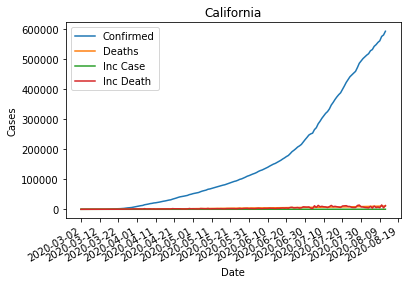

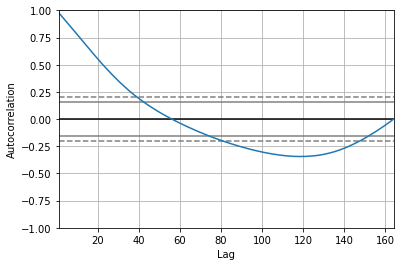

ARIMA(1, 0, 0) MSE=67609636.384
ARIMA(1, 1, 0) MSE=13467917.340
ARIMA(1, 2, 0) MSE=9589409.934
ARIMA(1, 2, 2) MSE=8167897.277
ARIMA(2, 1, 0) MSE=9571228.705
ARIMA(2, 2, 0) MSE=10823613.775
ARIMA(3, 1, 0) MSE=10791803.643
ARIMA(3, 2, 0) MSE=10334403.810
ARIMA(4, 1, 0) MSE=10437826.296
ARIMA(4, 2, 0) MSE=10510477.439
ARIMA(4, 2, 1) MSE=9063367.129
ARIMA(5, 1, 0) MSE=10624346.137
ARIMA(6, 1, 0) MSE=7918155.030
Best ARIMA(6, 1, 0) MSE=7918155.030
predicted=165997.111409, expected=167133.000000
predicted=170794.587731, expected=170862.000000
predicted=174270.915701, expected=175243.000000
predicted=179189.876152, expected=178657.000000
predicted=182387.525940, expected=184765.000000
predicted=188885.013074, expected=191477.000000
predicted=196777.811327, expected=196024.000000
predicted=201110.589879, expected=201112.000000
predicted=206470.537286, expected=206844.000000
predicted=211887.218212, expected=210692.000000
predicted=215633.020292, expected=215487.000000
predicted=220809.708910, 

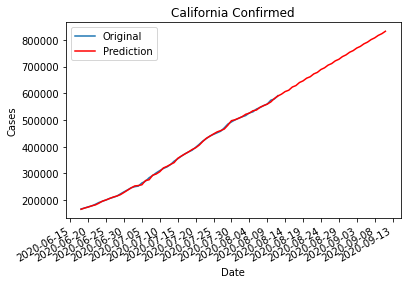

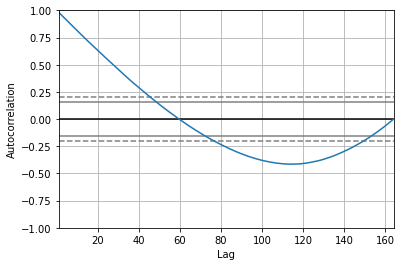

ARIMA(1, 0, 0) MSE=12881.986
ARIMA(1, 1, 0) MSE=3465.199
ARIMA(1, 1, 1) MSE=3527.738
ARIMA(1, 1, 2) MSE=3077.663
ARIMA(1, 2, 0) MSE=3877.302
ARIMA(2, 1, 0) MSE=3508.248
ARIMA(2, 1, 1) MSE=19306828.942
ARIMA(2, 1, 2) MSE=3373.817
ARIMA(2, 2, 0) MSE=4153.248
ARIMA(2, 2, 2) MSE=2372.475
ARIMA(3, 1, 0) MSE=3707.742
ARIMA(3, 1, 1) MSE=3134.936
ARIMA(3, 1, 2) MSE=2585.332
ARIMA(3, 2, 0) MSE=3604.054
ARIMA(3, 2, 2) MSE=1970.783
ARIMA(4, 1, 0) MSE=3468.032
ARIMA(4, 1, 1) MSE=2636.968
ARIMA(4, 1, 2) MSE=2027.137
ARIMA(4, 2, 0) MSE=3665.974
ARIMA(4, 2, 1) MSE=2521.782
ARIMA(4, 2, 2) MSE=2054.858
ARIMA(5, 1, 0) MSE=3575.756
ARIMA(5, 1, 1) MSE=2656.313
ARIMA(5, 2, 0) MSE=1950.423
ARIMA(5, 2, 1) MSE=1518.973
ARIMA(6, 1, 0) MSE=2012.972
ARIMA(6, 2, 0) MSE=1746.934
ARIMA(6, 2, 1) MSE=1608.530
ARIMA(7, 2, 0) MSE=1511.902
ARIMA(7, 2, 1) MSE=1591.299
ARIMA(8, 1, 0) MSE=1617.604
ARIMA(8, 2, 0) MSE=1531.338
ARIMA(9, 2, 0) MSE=1481.819
Best ARIMA(9, 2, 0) MSE=1481.819
predicted=5343.568955, expected=5355.0

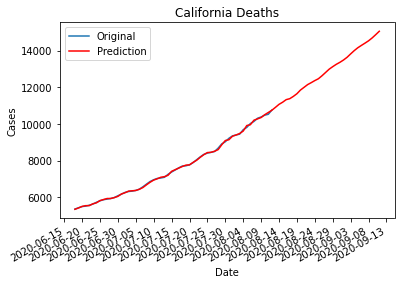

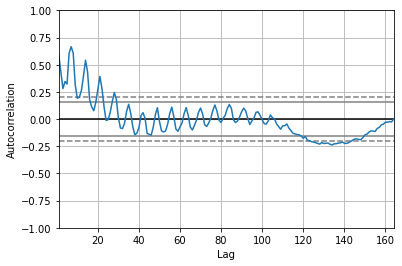

ARIMA(1, 0, 0) MSE=3472.531
ARIMA(1, 0, 1) MSE=3532.680
ARIMA(1, 0, 2) MSE=3077.129
ARIMA(1, 1, 0) MSE=3877.125
ARIMA(1, 2, 0) MSE=6454.260
ARIMA(2, 0, 0) MSE=3512.644
ARIMA(2, 0, 1) MSE=3166.780
ARIMA(2, 0, 2) MSE=3523.620
ARIMA(2, 1, 0) MSE=4153.109
ARIMA(2, 1, 2) MSE=2372.580
ARIMA(2, 2, 0) MSE=6792.893
ARIMA(3, 0, 0) MSE=3715.487
ARIMA(3, 0, 1) MSE=3134.526
ARIMA(3, 0, 2) MSE=2404.814
ARIMA(3, 1, 0) MSE=3603.913
ARIMA(3, 1, 2) MSE=1970.665
ARIMA(3, 2, 0) MSE=5693.272
ARIMA(4, 0, 0) MSE=3471.098
ARIMA(4, 0, 1) MSE=2636.547
ARIMA(4, 0, 2) MSE=2026.661
ARIMA(4, 1, 0) MSE=3665.882
ARIMA(4, 1, 1) MSE=2522.258
ARIMA(4, 1, 2) MSE=2054.952
ARIMA(4, 2, 0) MSE=5912.174
ARIMA(5, 0, 0) MSE=3578.349
ARIMA(5, 0, 1) MSE=2656.076
ARIMA(5, 1, 0) MSE=1957.246
ARIMA(5, 1, 1) MSE=1519.259
ARIMA(5, 2, 0) MSE=4293.339
ARIMA(6, 0, 0) MSE=2012.266
ARIMA(6, 0, 1) MSE=1620.616
ARIMA(6, 1, 0) MSE=1747.010
ARIMA(6, 1, 1) MSE=1608.856
ARIMA(6, 2, 0) MSE=3703.589
ARIMA(6, 2, 2) MSE=1711.934
ARIMA(7, 1, 0) MSE=1

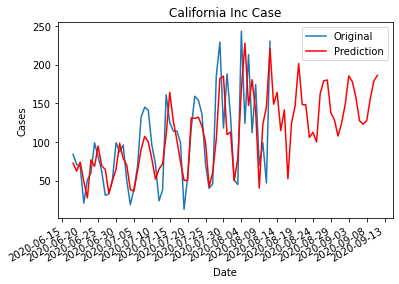

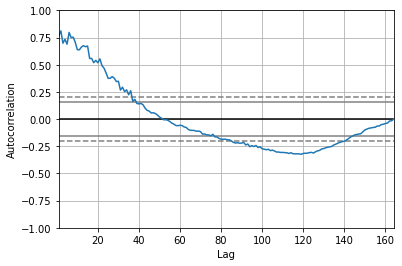

ARIMA(1, 0, 0) MSE=13475446.262
ARIMA(1, 1, 0) MSE=9588812.403
ARIMA(1, 1, 2) MSE=8164671.828
ARIMA(1, 2, 0) MSE=18140379.034
ARIMA(2, 0, 0) MSE=9570171.150
ARIMA(2, 1, 0) MSE=10824180.136
ARIMA(2, 2, 0) MSE=17206573.974
ARIMA(3, 0, 0) MSE=10791216.094
ARIMA(3, 1, 0) MSE=10334410.370
ARIMA(3, 2, 0) MSE=15523787.700
ARIMA(4, 0, 0) MSE=10440958.116
ARIMA(4, 1, 0) MSE=10510736.125
ARIMA(4, 1, 1) MSE=9069415.861
ARIMA(4, 2, 0) MSE=16244257.695
ARIMA(5, 0, 0) MSE=10621443.772
ARIMA(6, 0, 0) MSE=7902471.721
Best ARIMA(6, 0, 0) MSE=7902471.721
predicted=3199.256762, expected=4335.000000
predicted=3661.660144, expected=3729.000000
predicted=3409.019959, expected=4381.000000
predicted=3947.018708, expected=3414.000000
predicted=3730.821101, expected=6108.000000
predicted=4120.108114, expected=6712.000000
predicted=5300.453401, expected=4547.000000
predicted=5087.075349, expected=5088.000000
predicted=5359.021252, expected=5732.000000
predicted=5043.318647, expected=3848.000000
predicted=4938.42

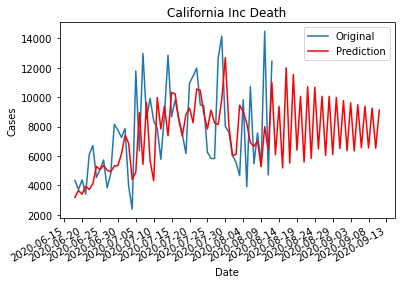

                      Confirmed     Deaths   Inc Case  Inc Death
US                          NaN        NaN        NaN        NaN
Alaska                      NaN        NaN        NaN        NaN
Alabama                     NaN        NaN        NaN        NaN
Arkansas                    NaN        NaN        NaN        NaN
Arizona               (1, 2, 1)  (6, 2, 0)  (6, 1, 0)  (1, 1, 1)
California            (6, 1, 0)  (9, 2, 0)  (9, 1, 0)  (6, 0, 0)
Colorado                    NaN        NaN        NaN        NaN
Connecticut                 NaN        NaN        NaN        NaN
District of Columbia        NaN        NaN        NaN        NaN
Delaware                    NaN        NaN        NaN        NaN
Florida                     NaN        NaN        NaN        NaN
Georgia                     NaN        NaN        NaN        NaN
Guam                        NaN        NaN        NaN        NaN
Hawaii                      NaN        NaN        NaN        NaN
Iowa                     

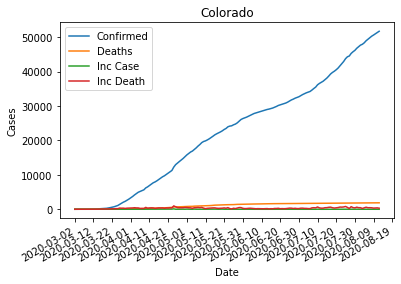

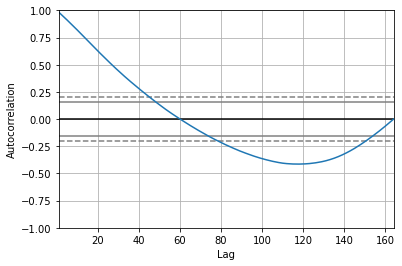

ARIMA(1, 0, 0) MSE=181587.107
ARIMA(1, 1, 0) MSE=17472.984
ARIMA(1, 1, 1) MSE=16687.899
ARIMA(1, 1, 2) MSE=15028.003
ARIMA(1, 2, 0) MSE=18436.172
ARIMA(1, 2, 1) MSE=15246.091
ARIMA(1, 2, 2) MSE=15281.328
ARIMA(2, 0, 0) MSE=19999.464
ARIMA(2, 1, 0) MSE=17118.729
ARIMA(2, 1, 1) MSE=15419.028
ARIMA(2, 1, 2) MSE=15416.901
ARIMA(2, 2, 0) MSE=16599.059
ARIMA(2, 2, 1) MSE=15388.702
ARIMA(2, 2, 2) MSE=15046.732
ARIMA(3, 1, 0) MSE=16245.517
ARIMA(3, 1, 1) MSE=15505.598
ARIMA(3, 1, 2) MSE=15819.521
ARIMA(3, 2, 0) MSE=17455.941
ARIMA(3, 2, 1) MSE=16056.637
ARIMA(3, 2, 2) MSE=16811.790
ARIMA(4, 0, 0) MSE=16868.482
ARIMA(4, 1, 0) MSE=16954.335
ARIMA(4, 1, 1) MSE=16150.507
ARIMA(4, 2, 0) MSE=16463.987
ARIMA(4, 2, 1) MSE=14922.022
ARIMA(5, 1, 0) MSE=16289.020
ARIMA(5, 1, 1) MSE=15044.942
ARIMA(5, 2, 0) MSE=15099.093
ARIMA(5, 2, 1) MSE=14554.138
ARIMA(6, 1, 0) MSE=15108.995
ARIMA(6, 1, 1) MSE=14669.771
ARIMA(6, 2, 0) MSE=14304.003
ARIMA(6, 2, 1) MSE=14784.432
ARIMA(7, 1, 0) MSE=14414.371
ARIMA(7, 1, 1

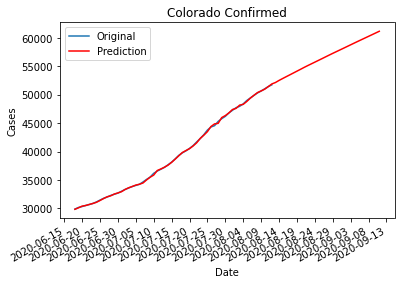

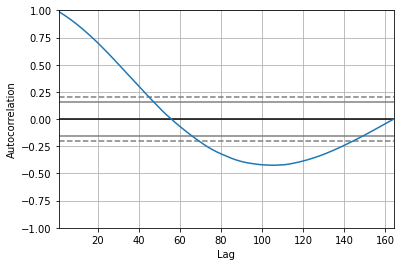

ARIMA(1, 0, 0) MSE=44.992
ARIMA(1, 1, 0) MSE=54.500
ARIMA(1, 1, 1) MSE=30.663
ARIMA(1, 2, 0) MSE=39.086
ARIMA(1, 2, 1) MSE=30.825
ARIMA(1, 2, 2) MSE=30.751
ARIMA(2, 0, 0) MSE=36.077
ARIMA(2, 1, 0) MSE=47.920
ARIMA(2, 1, 1) MSE=30.835
ARIMA(2, 1, 2) MSE=30.134
ARIMA(2, 2, 0) MSE=35.108
ARIMA(2, 2, 1) MSE=30.651
ARIMA(2, 2, 2) MSE=28.308
ARIMA(3, 0, 0) MSE=33.273
ARIMA(3, 1, 0) MSE=42.417
ARIMA(3, 1, 1) MSE=30.760
ARIMA(3, 2, 0) MSE=35.101
ARIMA(3, 2, 1) MSE=30.581
ARIMA(3, 2, 2) MSE=30.738
ARIMA(4, 0, 0) MSE=31.479
ARIMA(4, 1, 0) MSE=39.472
ARIMA(4, 1, 1) MSE=30.750
ARIMA(4, 1, 2) MSE=30.807
ARIMA(4, 2, 0) MSE=34.428
ARIMA(4, 2, 1) MSE=30.707
ARIMA(4, 2, 2) MSE=30.979
ARIMA(5, 0, 0) MSE=32.210
ARIMA(5, 1, 0) MSE=39.291
ARIMA(5, 1, 1) MSE=30.863
ARIMA(5, 1, 2) MSE=30.536
ARIMA(5, 2, 0) MSE=30.922
ARIMA(5, 2, 1) MSE=29.115
ARIMA(5, 2, 2) MSE=30.162
ARIMA(6, 0, 0) MSE=32.231
ARIMA(6, 1, 0) MSE=34.716
ARIMA(6, 1, 1) MSE=29.587
ARIMA(6, 2, 0) MSE=29.127
ARIMA(6, 2, 1) MSE=28.967
ARIMA(6, 2, 

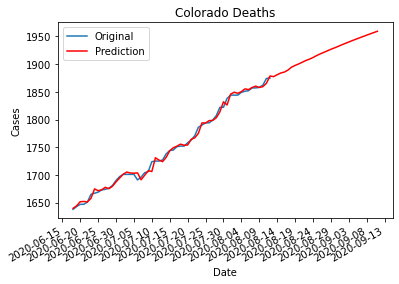

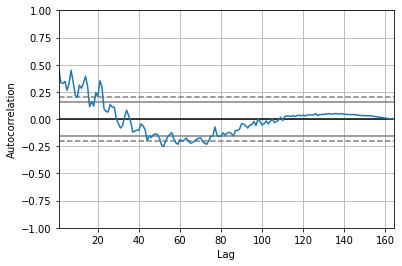

ARIMA(1, 0, 0) MSE=53.714
ARIMA(1, 0, 1) MSE=30.559
ARIMA(1, 1, 0) MSE=39.083
ARIMA(1, 1, 1) MSE=30.828
ARIMA(1, 1, 2) MSE=30.753
ARIMA(1, 2, 0) MSE=84.474
ARIMA(2, 0, 0) MSE=47.256
ARIMA(2, 0, 1) MSE=30.742
ARIMA(2, 0, 2) MSE=31.441
ARIMA(2, 1, 0) MSE=35.105
ARIMA(2, 1, 1) MSE=30.651
ARIMA(2, 1, 2) MSE=28.206
ARIMA(2, 2, 0) MSE=62.414
ARIMA(3, 0, 0) MSE=41.904
ARIMA(3, 0, 1) MSE=30.673
ARIMA(3, 1, 0) MSE=35.098
ARIMA(3, 1, 1) MSE=30.580
ARIMA(3, 1, 2) MSE=30.738
ARIMA(3, 2, 0) MSE=55.317
ARIMA(3, 2, 1) MSE=36.300
ARIMA(3, 2, 2) MSE=49.397
ARIMA(4, 0, 0) MSE=39.111
ARIMA(4, 0, 1) MSE=30.664
ARIMA(4, 0, 2) MSE=30.426
ARIMA(4, 1, 0) MSE=34.425
ARIMA(4, 1, 1) MSE=30.706
ARIMA(4, 1, 2) MSE=30.979
ARIMA(4, 2, 0) MSE=54.491
ARIMA(4, 2, 1) MSE=35.732
ARIMA(5, 0, 0) MSE=38.918
ARIMA(5, 0, 1) MSE=30.774
ARIMA(5, 0, 2) MSE=30.880
ARIMA(5, 1, 0) MSE=30.918
ARIMA(5, 1, 1) MSE=29.111
ARIMA(5, 1, 2) MSE=30.153
ARIMA(5, 2, 0) MSE=50.739
ARIMA(5, 2, 1) MSE=32.615
ARIMA(5, 2, 2) MSE=44.635
ARIMA(6, 0, 

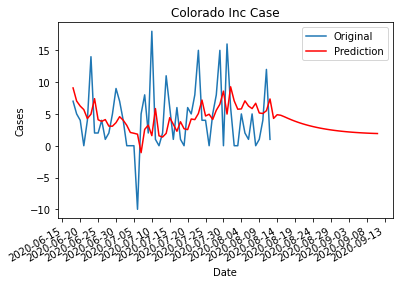

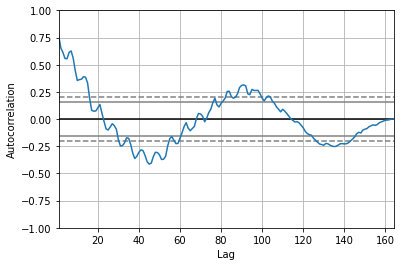

ARIMA(1, 0, 0) MSE=17515.493
ARIMA(1, 0, 1) MSE=16702.045
ARIMA(1, 0, 2) MSE=15026.268
ARIMA(1, 1, 0) MSE=18435.161
ARIMA(1, 1, 1) MSE=15245.096
ARIMA(1, 1, 2) MSE=15280.446
ARIMA(1, 2, 0) MSE=38696.678
ARIMA(2, 0, 0) MSE=17144.786
ARIMA(2, 0, 1) MSE=15416.731
ARIMA(2, 0, 2) MSE=15415.211
ARIMA(2, 1, 0) MSE=16598.044
ARIMA(2, 1, 1) MSE=15387.854
ARIMA(2, 1, 2) MSE=15044.344
ARIMA(2, 2, 0) MSE=26615.476
ARIMA(3, 0, 0) MSE=16252.839
ARIMA(3, 0, 1) MSE=15504.385
ARIMA(3, 0, 2) MSE=15765.034
ARIMA(3, 1, 0) MSE=17455.122
ARIMA(3, 1, 1) MSE=16056.004
ARIMA(3, 1, 2) MSE=16801.773
ARIMA(3, 2, 0) MSE=26337.321
ARIMA(4, 0, 0) MSE=16966.866
ARIMA(4, 0, 1) MSE=16150.827
ARIMA(4, 1, 0) MSE=16463.228
ARIMA(4, 1, 1) MSE=14921.542
ARIMA(4, 2, 0) MSE=25507.587
ARIMA(4, 2, 2) MSE=16376.010
ARIMA(5, 0, 0) MSE=16293.302
ARIMA(5, 0, 1) MSE=15043.839
ARIMA(5, 1, 0) MSE=15098.694
ARIMA(5, 1, 1) MSE=14553.871
ARIMA(5, 2, 0) MSE=24526.359
ARIMA(5, 2, 1) MSE=15905.347
ARIMA(5, 2, 2) MSE=16282.023
ARIMA(6, 0, 0)

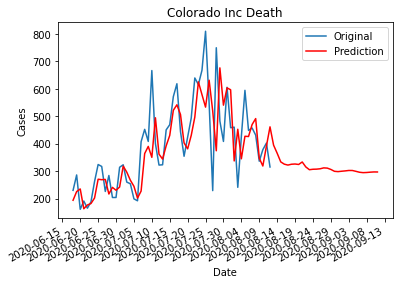

                      Confirmed     Deaths   Inc Case  Inc Death
US                          NaN        NaN        NaN        NaN
Alaska                      NaN        NaN        NaN        NaN
Alabama                     NaN        NaN        NaN        NaN
Arkansas                    NaN        NaN        NaN        NaN
Arizona               (1, 2, 1)  (6, 2, 0)  (6, 1, 0)  (1, 1, 1)
California            (6, 1, 0)  (9, 2, 0)  (9, 1, 0)  (6, 0, 0)
Colorado              (9, 1, 1)  (9, 0, 0)  (2, 1, 2)  (9, 0, 1)
Connecticut                 NaN        NaN        NaN        NaN
District of Columbia        NaN        NaN        NaN        NaN
Delaware                    NaN        NaN        NaN        NaN
Florida                     NaN        NaN        NaN        NaN
Georgia                     NaN        NaN        NaN        NaN
Guam                        NaN        NaN        NaN        NaN
Hawaii                      NaN        NaN        NaN        NaN
Iowa                     

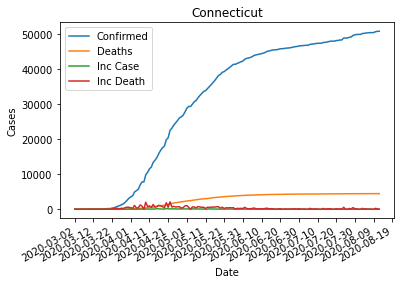

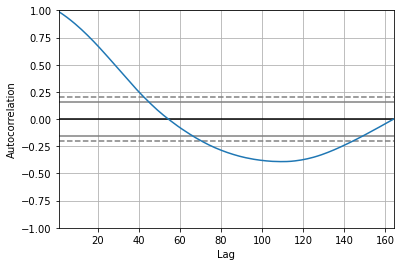

ARIMA(1, 0, 0) MSE=20019.164
ARIMA(1, 1, 0) MSE=37316.533
ARIMA(1, 1, 1) MSE=13587.891
ARIMA(1, 1, 2) MSE=13074.540
ARIMA(1, 2, 0) MSE=18681.138
ARIMA(1, 2, 1) MSE=13342.253
ARIMA(1, 2, 2) MSE=13162.278
ARIMA(2, 0, 0) MSE=20503.208
ARIMA(2, 0, 2) MSE=13554.172
ARIMA(2, 1, 0) MSE=20341.995
ARIMA(2, 1, 1) MSE=13382.877
ARIMA(2, 1, 2) MSE=13230.331
ARIMA(2, 2, 0) MSE=16168.818
ARIMA(2, 2, 1) MSE=13315.382
ARIMA(2, 2, 2) MSE=13033.961
ARIMA(3, 0, 0) MSE=17205.236
ARIMA(3, 0, 1) MSE=13423.540
ARIMA(3, 0, 2) MSE=13662.663
ARIMA(3, 1, 0) MSE=16576.866
ARIMA(3, 1, 1) MSE=13370.321
ARIMA(3, 2, 0) MSE=14993.096
ARIMA(3, 2, 1) MSE=13551.499
ARIMA(3, 2, 2) MSE=13671.338
ARIMA(4, 0, 0) MSE=15437.246
ARIMA(4, 0, 1) MSE=13339.180
ARIMA(4, 0, 2) MSE=16112.877
ARIMA(4, 1, 0) MSE=14937.838
ARIMA(4, 1, 1) MSE=14111.428
ARIMA(4, 1, 2) MSE=13837.819
ARIMA(4, 2, 0) MSE=14525.920
ARIMA(4, 2, 1) MSE=13809.345
ARIMA(4, 2, 2) MSE=13921.998
ARIMA(5, 0, 0) MSE=14981.560
ARIMA(5, 0, 1) MSE=13742.402
ARIMA(5, 0, 2)

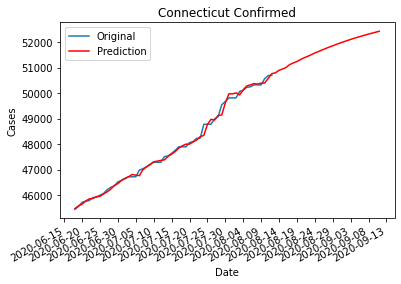

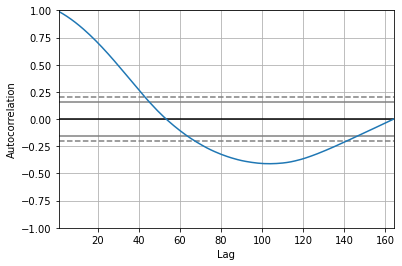

ARIMA(1, 0, 0) MSE=43.041
ARIMA(1, 1, 0) MSE=98.989
ARIMA(1, 1, 1) MSE=23.379
ARIMA(1, 1, 2) MSE=23.211
ARIMA(1, 2, 0) MSE=26.670
ARIMA(1, 2, 1) MSE=20.795
ARIMA(1, 2, 2) MSE=21.155
ARIMA(2, 0, 1) MSE=31.834
ARIMA(2, 0, 2) MSE=30.406
ARIMA(2, 1, 0) MSE=48.969
ARIMA(2, 1, 1) MSE=23.232
ARIMA(2, 1, 2) MSE=23.580
ARIMA(2, 2, 0) MSE=23.210
ARIMA(2, 2, 1) MSE=20.650
ARIMA(2, 2, 2) MSE=20.822
ARIMA(3, 0, 0) MSE=24.621
ARIMA(3, 0, 1) MSE=28.312
ARIMA(3, 0, 2) MSE=32.282
ARIMA(3, 1, 0) MSE=37.852
ARIMA(3, 1, 1) MSE=23.034
ARIMA(3, 1, 2) MSE=23.233
ARIMA(3, 2, 0) MSE=21.587
ARIMA(3, 2, 1) MSE=21.787
ARIMA(3, 2, 2) MSE=20.843
ARIMA(4, 0, 0) MSE=22.180
ARIMA(4, 0, 1) MSE=27.186
ARIMA(4, 0, 2) MSE=29.892
ARIMA(4, 1, 0) MSE=29.478
ARIMA(4, 1, 1) MSE=23.683
ARIMA(4, 1, 2) MSE=23.273
ARIMA(4, 2, 0) MSE=25.476
ARIMA(4, 2, 1) MSE=25.789
ARIMA(4, 2, 2) MSE=24.697
ARIMA(5, 0, 0) MSE=20.879
ARIMA(5, 0, 1) MSE=28.096
ARIMA(5, 0, 2) MSE=27.254
ARIMA(5, 1, 0) MSE=27.710
ARIMA(5, 1, 1) MSE=28.587
ARIMA(5, 1, 

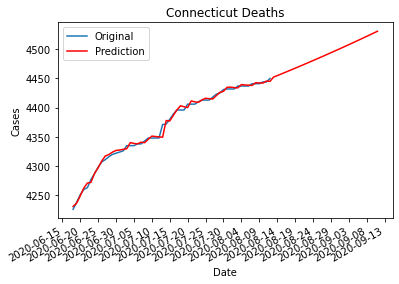

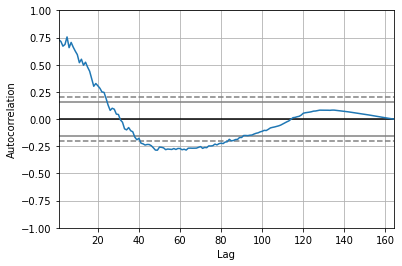

ARIMA(1, 0, 0) MSE=96.928
ARIMA(1, 0, 1) MSE=23.308
ARIMA(1, 0, 2) MSE=23.140
ARIMA(1, 1, 0) MSE=26.668
ARIMA(1, 1, 1) MSE=20.791
ARIMA(1, 1, 2) MSE=21.151
ARIMA(1, 2, 0) MSE=62.276
ARIMA(2, 0, 0) MSE=48.216
ARIMA(2, 0, 1) MSE=23.162
ARIMA(2, 0, 2) MSE=23.509
ARIMA(2, 1, 0) MSE=23.208
ARIMA(2, 1, 1) MSE=20.646
ARIMA(2, 1, 2) MSE=20.818
ARIMA(2, 2, 0) MSE=45.667
ARIMA(3, 0, 0) MSE=37.365
ARIMA(3, 0, 1) MSE=22.965
ARIMA(3, 0, 2) MSE=23.163
ARIMA(3, 1, 0) MSE=21.585
ARIMA(3, 1, 1) MSE=21.783
ARIMA(3, 1, 2) MSE=20.839
ARIMA(3, 2, 0) MSE=37.206
ARIMA(4, 0, 0) MSE=29.225
ARIMA(4, 0, 1) MSE=23.628
ARIMA(4, 0, 2) MSE=23.202
ARIMA(4, 1, 0) MSE=25.475
ARIMA(4, 1, 1) MSE=25.788
ARIMA(4, 1, 2) MSE=24.695
ARIMA(4, 2, 0) MSE=39.414
ARIMA(4, 2, 1) MSE=43.095
ARIMA(5, 0, 0) MSE=27.643
ARIMA(5, 0, 1) MSE=28.501
ARIMA(5, 0, 2) MSE=26.397
ARIMA(5, 1, 0) MSE=25.692
ARIMA(5, 1, 1) MSE=25.106
ARIMA(5, 1, 2) MSE=24.789
ARIMA(5, 2, 0) MSE=39.228
ARIMA(6, 0, 0) MSE=28.187
ARIMA(6, 0, 1) MSE=27.968
ARIMA(6, 0, 

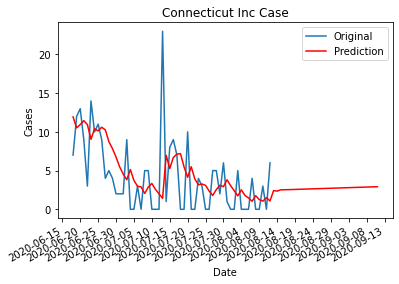

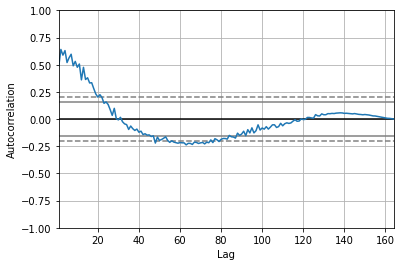

ARIMA(1, 0, 0) MSE=36626.675
ARIMA(1, 0, 1) MSE=13574.445
ARIMA(1, 0, 2) MSE=13061.507
ARIMA(1, 1, 0) MSE=18680.588
ARIMA(1, 1, 1) MSE=13341.096
ARIMA(1, 1, 2) MSE=13161.079
ARIMA(1, 2, 0) MSE=42985.531
ARIMA(2, 0, 0) MSE=20191.759
ARIMA(2, 0, 1) MSE=13372.059
ARIMA(2, 0, 2) MSE=13217.621
ARIMA(2, 1, 0) MSE=16167.951
ARIMA(2, 1, 1) MSE=13314.278
ARIMA(2, 1, 2) MSE=13033.799
ARIMA(2, 2, 0) MSE=31434.063
ARIMA(3, 0, 0) MSE=16521.658
ARIMA(3, 0, 1) MSE=13359.705
ARIMA(3, 1, 0) MSE=14992.281
ARIMA(3, 1, 1) MSE=13550.390
ARIMA(3, 1, 2) MSE=13670.269
ARIMA(3, 2, 0) MSE=28887.546
ARIMA(3, 2, 1) MSE=17285.652
ARIMA(4, 0, 0) MSE=14920.617
ARIMA(4, 0, 1) MSE=14090.700
ARIMA(4, 0, 2) MSE=13825.674
ARIMA(4, 1, 0) MSE=14525.186
ARIMA(4, 1, 1) MSE=13808.301
ARIMA(4, 1, 2) MSE=13920.989
ARIMA(4, 2, 0) MSE=23652.304
ARIMA(4, 2, 1) MSE=16990.285
ARIMA(5, 0, 0) MSE=14592.354
ARIMA(5, 0, 1) MSE=13896.250
ARIMA(5, 0, 2) MSE=13987.148
ARIMA(5, 1, 0) MSE=14417.424
ARIMA(5, 1, 1) MSE=14000.400
ARIMA(5, 1, 2)

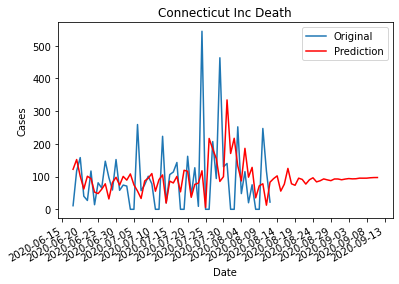

                      Confirmed     Deaths   Inc Case  Inc Death
US                          NaN        NaN        NaN        NaN
Alaska                      NaN        NaN        NaN        NaN
Alabama                     NaN        NaN        NaN        NaN
Arkansas                    NaN        NaN        NaN        NaN
Arizona               (1, 2, 1)  (6, 2, 0)  (6, 1, 0)  (1, 1, 1)
California            (6, 1, 0)  (9, 2, 0)  (9, 1, 0)  (6, 0, 0)
Colorado              (9, 1, 1)  (9, 0, 0)  (2, 1, 2)  (9, 0, 1)
Connecticut           (8, 0, 0)  (2, 2, 1)  (2, 1, 1)  (7, 1, 1)
District of Columbia        NaN        NaN        NaN        NaN
Delaware                    NaN        NaN        NaN        NaN
Florida                     NaN        NaN        NaN        NaN
Georgia                     NaN        NaN        NaN        NaN
Guam                        NaN        NaN        NaN        NaN
Hawaii                      NaN        NaN        NaN        NaN
Iowa                     

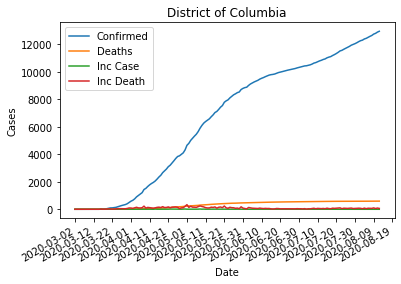

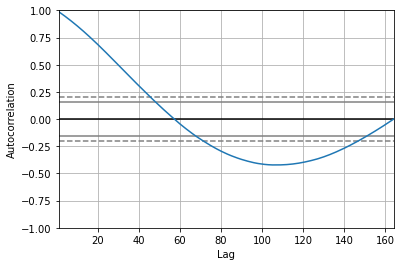

ARIMA(1, 0, 0) MSE=3562.186
ARIMA(1, 1, 0) MSE=465.867
ARIMA(1, 1, 1) MSE=269.952
ARIMA(1, 1, 2) MSE=280.940
ARIMA(1, 2, 0) MSE=345.116
ARIMA(1, 2, 1) MSE=282.493
ARIMA(1, 2, 2) MSE=282.586
ARIMA(2, 0, 0) MSE=512.826
ARIMA(2, 1, 0) MSE=328.344
ARIMA(2, 1, 1) MSE=281.156
ARIMA(2, 1, 2) MSE=284.003
ARIMA(2, 2, 0) MSE=315.325
ARIMA(2, 2, 1) MSE=282.820
ARIMA(2, 2, 2) MSE=282.228
ARIMA(3, 0, 0) MSE=348.654
ARIMA(3, 1, 0) MSE=303.653
ARIMA(3, 1, 1) MSE=281.465
ARIMA(3, 2, 0) MSE=313.546
ARIMA(3, 2, 1) MSE=287.096
ARIMA(4, 0, 0) MSE=317.459
ARIMA(4, 1, 0) MSE=301.890
ARIMA(4, 1, 1) MSE=286.165
ARIMA(4, 2, 0) MSE=286.147
ARIMA(4, 2, 1) MSE=276.394
ARIMA(4, 2, 2) MSE=288.200
ARIMA(5, 0, 0) MSE=319.274
ARIMA(5, 1, 0) MSE=279.740
ARIMA(5, 1, 1) MSE=275.832
ARIMA(5, 2, 0) MSE=287.725
ARIMA(5, 2, 1) MSE=277.993
ARIMA(5, 2, 2) MSE=289.650
ARIMA(6, 0, 0) MSE=291.709
ARIMA(6, 1, 0) MSE=283.526
ARIMA(6, 1, 1) MSE=277.464
ARIMA(6, 1, 2) MSE=272.785
ARIMA(6, 2, 0) MSE=266.085
ARIMA(6, 2, 1) MSE=266.518


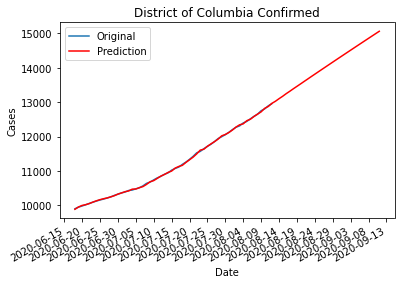

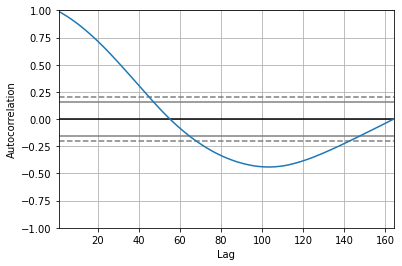

ARIMA(1, 0, 0) MSE=3.075
ARIMA(1, 1, 0) MSE=2.328
ARIMA(1, 1, 1) MSE=1.276
ARIMA(1, 1, 2) MSE=1.332
ARIMA(1, 2, 0) MSE=1.529
ARIMA(1, 2, 1) MSE=1.345
ARIMA(1, 2, 2) MSE=1.325
ARIMA(2, 0, 0) MSE=2.095
ARIMA(2, 1, 0) MSE=1.679
ARIMA(2, 1, 1) MSE=1.326
ARIMA(2, 1, 2) MSE=1.306
ARIMA(2, 2, 0) MSE=1.497
ARIMA(2, 2, 1) MSE=1.347
ARIMA(2, 2, 2) MSE=1.343
ARIMA(3, 0, 0) MSE=1.409
ARIMA(3, 1, 0) MSE=1.573
ARIMA(3, 1, 1) MSE=1.329
ARIMA(3, 1, 2) MSE=1.279
ARIMA(3, 2, 0) MSE=1.475
ARIMA(3, 2, 1) MSE=1.348
ARIMA(3, 2, 2) MSE=1.321
ARIMA(4, 0, 0) MSE=1.421
ARIMA(4, 1, 0) MSE=1.506
ARIMA(4, 1, 1) MSE=1.327
ARIMA(4, 2, 0) MSE=1.423
ARIMA(4, 2, 1) MSE=1.343
ARIMA(4, 2, 2) MSE=1.409
ARIMA(5, 0, 0) MSE=1.409
ARIMA(5, 1, 0) MSE=1.431
ARIMA(5, 1, 1) MSE=1.318
ARIMA(5, 1, 2) MSE=1.619
ARIMA(5, 2, 0) MSE=1.423
ARIMA(5, 2, 1) MSE=1.362
ARIMA(5, 2, 2) MSE=1.350
ARIMA(6, 0, 0) MSE=1.422
ARIMA(6, 1, 0) MSE=1.404
ARIMA(6, 1, 1) MSE=1.334
ARIMA(6, 1, 2) MSE=1.325
ARIMA(6, 2, 0) MSE=1.375
ARIMA(6, 2, 1) MSE=1.355


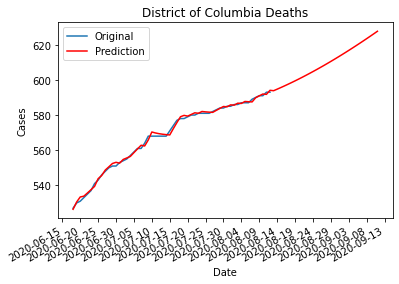

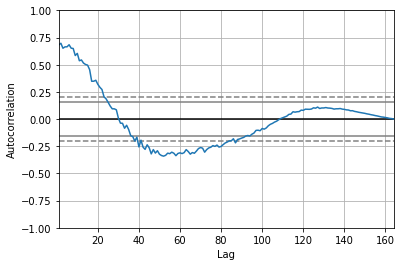

ARIMA(1, 0, 0) MSE=2.293
ARIMA(1, 0, 1) MSE=1.275
ARIMA(1, 0, 2) MSE=1.330
ARIMA(1, 1, 0) MSE=1.528
ARIMA(1, 1, 1) MSE=1.344
ARIMA(1, 1, 2) MSE=1.325
ARIMA(1, 2, 0) MSE=3.035
ARIMA(2, 0, 0) MSE=1.668
ARIMA(2, 0, 1) MSE=1.325
ARIMA(2, 0, 2) MSE=1.305
ARIMA(2, 1, 0) MSE=1.497
ARIMA(2, 1, 1) MSE=1.347
ARIMA(2, 1, 2) MSE=1.343
ARIMA(2, 2, 0) MSE=2.478
ARIMA(3, 0, 0) MSE=1.566
ARIMA(3, 0, 1) MSE=1.328
ARIMA(3, 0, 2) MSE=1.302
ARIMA(3, 1, 0) MSE=1.475
ARIMA(3, 1, 1) MSE=1.348
ARIMA(3, 1, 2) MSE=1.346
ARIMA(3, 2, 0) MSE=2.297
ARIMA(4, 0, 0) MSE=1.502
ARIMA(4, 0, 1) MSE=1.326
ARIMA(4, 1, 0) MSE=1.423
ARIMA(4, 1, 1) MSE=1.343
ARIMA(4, 1, 2) MSE=1.409
ARIMA(4, 2, 0) MSE=2.081
ARIMA(5, 0, 0) MSE=1.429
ARIMA(5, 0, 1) MSE=1.317
ARIMA(5, 0, 2) MSE=1.647
ARIMA(5, 1, 0) MSE=1.423
ARIMA(5, 1, 1) MSE=1.361
ARIMA(5, 1, 2) MSE=1.350
ARIMA(5, 2, 0) MSE=2.092
ARIMA(6, 0, 0) MSE=1.403
ARIMA(6, 0, 1) MSE=1.333
ARIMA(6, 0, 2) MSE=1.324
ARIMA(6, 1, 0) MSE=1.375
ARIMA(6, 1, 1) MSE=1.355
ARIMA(6, 1, 2) MSE=1.351


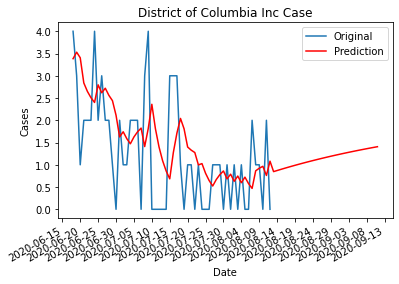

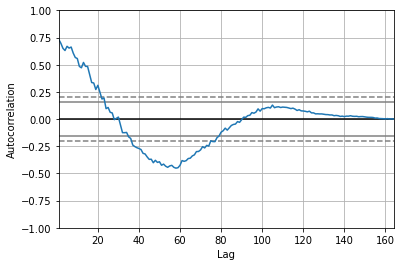

ARIMA(1, 0, 0) MSE=463.163
ARIMA(1, 0, 1) MSE=270.039
ARIMA(1, 0, 2) MSE=281.017
ARIMA(1, 1, 0) MSE=345.099
ARIMA(1, 1, 1) MSE=282.481
ARIMA(1, 1, 2) MSE=282.574
ARIMA(1, 2, 0) MSE=796.617
ARIMA(2, 0, 0) MSE=327.403
ARIMA(2, 0, 1) MSE=281.235
ARIMA(2, 0, 2) MSE=281.300
ARIMA(2, 1, 0) MSE=315.310
ARIMA(2, 1, 1) MSE=282.808
ARIMA(2, 1, 2) MSE=282.216
ARIMA(2, 2, 0) MSE=560.016
ARIMA(3, 0, 0) MSE=303.166
ARIMA(3, 0, 1) MSE=281.546
ARIMA(3, 1, 0) MSE=313.535
ARIMA(3, 1, 1) MSE=287.089
ARIMA(3, 2, 0) MSE=523.392
ARIMA(4, 0, 0) MSE=301.727
ARIMA(4, 0, 1) MSE=286.254
ARIMA(4, 1, 0) MSE=286.141
ARIMA(4, 1, 1) MSE=276.392
ARIMA(4, 1, 2) MSE=288.210
ARIMA(4, 2, 0) MSE=444.850
ARIMA(5, 0, 0) MSE=279.811
ARIMA(5, 0, 1) MSE=275.917
ARIMA(5, 1, 0) MSE=287.723
ARIMA(5, 1, 1) MSE=277.993
ARIMA(5, 1, 2) MSE=289.658
ARIMA(5, 2, 0) MSE=448.091
ARIMA(6, 0, 0) MSE=283.627
ARIMA(6, 0, 1) MSE=277.551
ARIMA(6, 0, 2) MSE=287.873
ARIMA(6, 1, 0) MSE=266.084
ARIMA(6, 1, 1) MSE=266.517
ARIMA(6, 1, 2) MSE=277.748
A

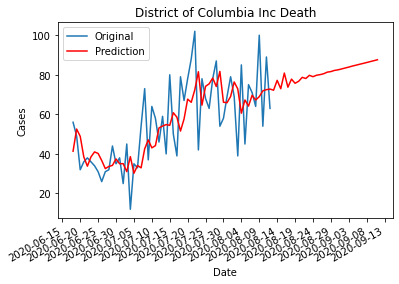

                      Confirmed     Deaths   Inc Case  Inc Death
US                          NaN        NaN        NaN        NaN
Alaska                      NaN        NaN        NaN        NaN
Alabama                     NaN        NaN        NaN        NaN
Arkansas                    NaN        NaN        NaN        NaN
Arizona               (1, 2, 1)  (6, 2, 0)  (6, 1, 0)  (1, 1, 1)
California            (6, 1, 0)  (9, 2, 0)  (9, 1, 0)  (6, 0, 0)
Colorado              (9, 1, 1)  (9, 0, 0)  (2, 1, 2)  (9, 0, 1)
Connecticut           (8, 0, 0)  (2, 2, 1)  (2, 1, 1)  (7, 1, 1)
District of Columbia  (7, 1, 0)  (1, 1, 1)  (1, 0, 1)  (6, 1, 0)
Delaware                    NaN        NaN        NaN        NaN
Florida                     NaN        NaN        NaN        NaN
Georgia                     NaN        NaN        NaN        NaN
Guam                        NaN        NaN        NaN        NaN
Hawaii                      NaN        NaN        NaN        NaN
Iowa                     

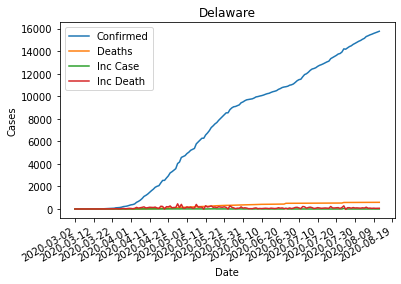

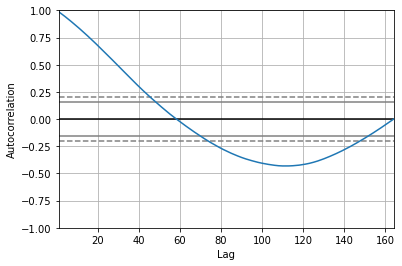

ARIMA(1, 0, 0) MSE=11827.461
ARIMA(1, 1, 0) MSE=3112.604
ARIMA(1, 1, 2) MSE=2787.956
ARIMA(1, 2, 0) MSE=4427.518
ARIMA(1, 2, 1) MSE=2901.018
ARIMA(1, 2, 2) MSE=2945.561
ARIMA(2, 0, 0) MSE=4955.949
ARIMA(2, 1, 0) MSE=3454.957
ARIMA(2, 1, 1) MSE=2845.678
ARIMA(2, 2, 0) MSE=3320.259
ARIMA(2, 2, 1) MSE=2813.847
ARIMA(2, 2, 2) MSE=3090.159
ARIMA(3, 0, 0) MSE=4249.323
ARIMA(3, 1, 0) MSE=2970.436
ARIMA(3, 1, 1) MSE=2753.325
ARIMA(3, 2, 0) MSE=2930.273
ARIMA(3, 2, 1) MSE=2858.235
ARIMA(3, 2, 2) MSE=2975.683
ARIMA(4, 0, 0) MSE=3361.055
ARIMA(4, 1, 0) MSE=2752.909
ARIMA(4, 1, 1) MSE=2791.949
ARIMA(4, 2, 0) MSE=3110.689
ARIMA(4, 2, 1) MSE=3086.088
ARIMA(4, 2, 2) MSE=3091.173
ARIMA(5, 0, 0) MSE=2906.750
ARIMA(5, 1, 0) MSE=2973.540
ARIMA(5, 1, 1) MSE=3009.518
ARIMA(5, 1, 2) MSE=3016.465
ARIMA(5, 2, 0) MSE=3240.889
ARIMA(5, 2, 1) MSE=3162.308
ARIMA(6, 0, 0) MSE=3050.724
ARIMA(6, 1, 0) MSE=3122.448
ARIMA(6, 1, 1) MSE=3215.300
ARIMA(6, 2, 0) MSE=3305.128
ARIMA(6, 2, 1) MSE=3172.548
ARIMA(7, 0, 0) MSE=

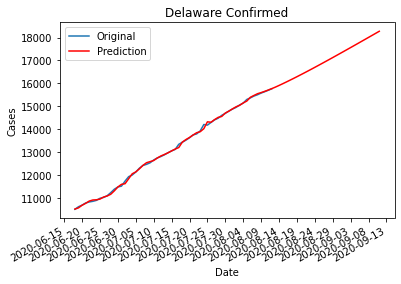

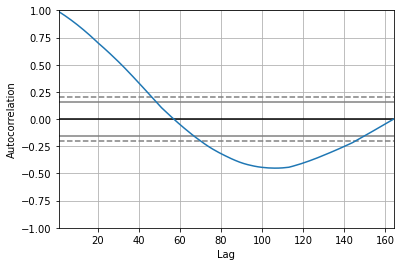

ARIMA(1, 0, 0) MSE=130.148
ARIMA(1, 1, 0) MSE=138.815
ARIMA(1, 1, 1) MSE=127.779
ARIMA(1, 2, 0) MSE=229.347
ARIMA(1, 2, 1) MSE=139.862
ARIMA(2, 0, 0) MSE=179.110
ARIMA(2, 1, 0) MSE=144.278
ARIMA(2, 2, 0) MSE=217.509
ARIMA(2, 2, 1) MSE=145.773
ARIMA(3, 0, 0) MSE=180.274
ARIMA(3, 1, 0) MSE=147.755
ARIMA(3, 2, 0) MSE=203.471
ARIMA(3, 2, 1) MSE=137.089
ARIMA(4, 1, 0) MSE=150.521
ARIMA(4, 1, 1) MSE=153.030
ARIMA(4, 2, 0) MSE=193.157
ARIMA(4, 2, 1) MSE=143.708
ARIMA(5, 0, 0) MSE=177.480
ARIMA(5, 1, 0) MSE=154.747
ARIMA(5, 1, 1) MSE=146.605
ARIMA(5, 2, 0) MSE=193.169
ARIMA(5, 2, 1) MSE=164.010
ARIMA(6, 0, 0) MSE=183.451
ARIMA(6, 1, 0) MSE=157.240
ARIMA(6, 1, 1) MSE=158.069
ARIMA(6, 2, 0) MSE=189.725
ARIMA(6, 2, 1) MSE=161.613
ARIMA(6, 2, 2) MSE=167.752
ARIMA(7, 0, 0) MSE=180.238
ARIMA(7, 1, 0) MSE=158.059
ARIMA(7, 1, 1) MSE=159.969
ARIMA(7, 2, 0) MSE=187.308
ARIMA(8, 0, 0) MSE=182.964
ARIMA(8, 1, 0) MSE=159.188
ARIMA(8, 1, 1) MSE=158.338
ARIMA(8, 2, 0) MSE=182.509
ARIMA(9, 1, 0) MSE=158.687
A

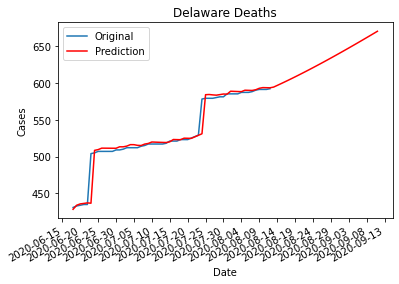

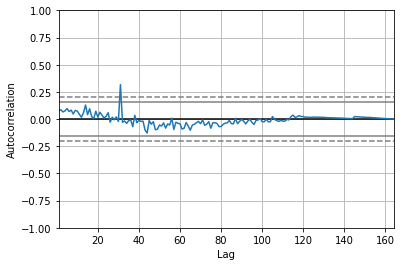

ARIMA(1, 0, 0) MSE=139.176
ARIMA(1, 0, 1) MSE=127.633
ARIMA(1, 1, 0) MSE=229.333
ARIMA(1, 1, 1) MSE=139.846
ARIMA(1, 2, 0) MSE=503.897
ARIMA(2, 0, 0) MSE=144.685
ARIMA(2, 1, 0) MSE=217.497
ARIMA(2, 1, 1) MSE=145.744
ARIMA(2, 2, 0) MSE=523.767
ARIMA(3, 0, 0) MSE=148.162
ARIMA(3, 1, 0) MSE=203.468
ARIMA(3, 1, 1) MSE=137.068
ARIMA(4, 0, 0) MSE=150.876
ARIMA(4, 0, 1) MSE=142.437
ARIMA(4, 1, 0) MSE=193.169
ARIMA(4, 1, 1) MSE=143.693
ARIMA(4, 2, 0) MSE=383.569
ARIMA(5, 0, 0) MSE=155.047
ARIMA(5, 0, 1) MSE=146.611
ARIMA(5, 1, 0) MSE=193.203
ARIMA(5, 1, 1) MSE=164.004
ARIMA(6, 0, 0) MSE=157.539
ARIMA(6, 0, 1) MSE=158.408
ARIMA(6, 1, 0) MSE=189.766
ARIMA(6, 1, 1) MSE=161.602
ARIMA(6, 1, 2) MSE=167.768
ARIMA(7, 0, 0) MSE=158.324
ARIMA(7, 0, 1) MSE=160.243
ARIMA(7, 1, 0) MSE=187.349
ARIMA(8, 0, 0) MSE=159.418
ARIMA(8, 0, 1) MSE=158.514
ARIMA(8, 1, 0) MSE=182.543
ARIMA(9, 0, 0) MSE=158.870
ARIMA(9, 0, 1) MSE=158.862
ARIMA(9, 1, 0) MSE=178.614
Best ARIMA(1, 0, 1) MSE=127.633
predicted=2.499863, exp

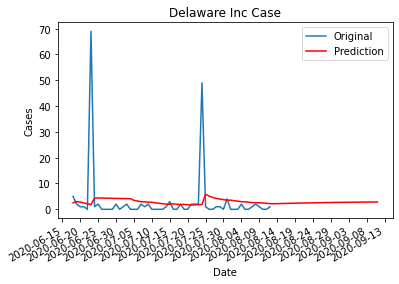

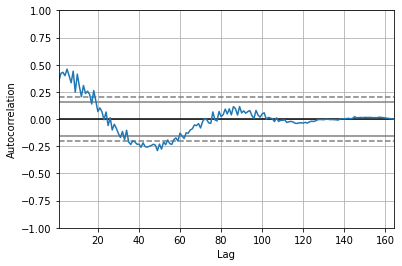

ARIMA(1, 0, 0) MSE=3124.881
ARIMA(1, 0, 2) MSE=2788.842
ARIMA(1, 1, 0) MSE=4427.299
ARIMA(1, 1, 1) MSE=2900.790
ARIMA(1, 1, 2) MSE=2930.511
ARIMA(1, 2, 0) MSE=11031.450
ARIMA(2, 0, 0) MSE=3465.444
ARIMA(2, 0, 1) MSE=2846.554
ARIMA(2, 1, 0) MSE=3320.033
ARIMA(2, 1, 1) MSE=2813.608
ARIMA(2, 1, 2) MSE=3090.436
ARIMA(2, 2, 0) MSE=7247.519
ARIMA(3, 0, 0) MSE=2974.742
ARIMA(3, 0, 1) MSE=2754.176
ARIMA(3, 1, 0) MSE=2930.026
ARIMA(3, 1, 1) MSE=2858.011
ARIMA(3, 1, 2) MSE=3005.570
ARIMA(3, 2, 0) MSE=5261.453
ARIMA(4, 0, 0) MSE=2755.166
ARIMA(4, 0, 1) MSE=2792.884
ARIMA(4, 0, 2) MSE=2984.492
ARIMA(4, 1, 0) MSE=3110.519
ARIMA(4, 1, 1) MSE=3085.927
ARIMA(4, 1, 2) MSE=3091.017
ARIMA(4, 2, 0) MSE=4383.792
ARIMA(4, 2, 1) MSE=3242.887
ARIMA(5, 0, 0) MSE=2975.438
ARIMA(5, 0, 1) MSE=3010.584
ARIMA(5, 0, 2) MSE=3017.474
ARIMA(5, 1, 0) MSE=3240.761
ARIMA(5, 1, 1) MSE=3162.093
ARIMA(5, 2, 0) MSE=5109.792
ARIMA(5, 2, 1) MSE=3415.192
ARIMA(5, 2, 2) MSE=3592.014
ARIMA(6, 0, 0) MSE=3124.036
ARIMA(6, 0, 1) MSE=

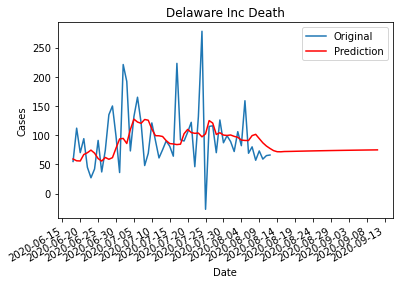

                      Confirmed     Deaths   Inc Case  Inc Death
US                          NaN        NaN        NaN        NaN
Alaska                      NaN        NaN        NaN        NaN
Alabama                     NaN        NaN        NaN        NaN
Arkansas                    NaN        NaN        NaN        NaN
Arizona               (1, 2, 1)  (6, 2, 0)  (6, 1, 0)  (1, 1, 1)
California            (6, 1, 0)  (9, 2, 0)  (9, 1, 0)  (6, 0, 0)
Colorado              (9, 1, 1)  (9, 0, 0)  (2, 1, 2)  (9, 0, 1)
Connecticut           (8, 0, 0)  (2, 2, 1)  (2, 1, 1)  (7, 1, 1)
District of Columbia  (7, 1, 0)  (1, 1, 1)  (1, 0, 1)  (6, 1, 0)
Delaware              (4, 1, 0)  (1, 1, 1)  (1, 0, 1)  (3, 0, 1)
Florida                     NaN        NaN        NaN        NaN
Georgia                     NaN        NaN        NaN        NaN
Guam                        NaN        NaN        NaN        NaN
Hawaii                      NaN        NaN        NaN        NaN
Iowa                     

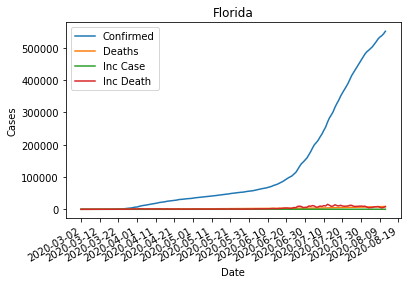

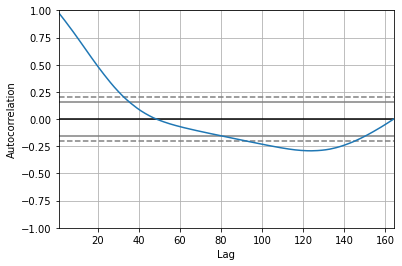

ARIMA(1, 0, 0) MSE=78403677.783
ARIMA(1, 1, 0) MSE=3889341.083
ARIMA(1, 2, 0) MSE=3919569.909
ARIMA(1, 2, 1) MSE=3899793.640
ARIMA(2, 1, 0) MSE=3963574.620
ARIMA(2, 2, 0) MSE=3968981.543
ARIMA(3, 1, 0) MSE=4045837.601
ARIMA(3, 2, 0) MSE=4089120.305
ARIMA(3, 2, 1) MSE=4026431.158
ARIMA(4, 1, 0) MSE=4130670.779
ARIMA(4, 2, 0) MSE=4259517.394
ARIMA(4, 2, 1) MSE=4190110.339
ARIMA(5, 1, 0) MSE=4282964.874
ARIMA(5, 2, 0) MSE=4094006.499
ARIMA(6, 1, 0) MSE=4150116.950
ARIMA(7, 1, 0) MSE=4474240.043
Best ARIMA(1, 1, 0) MSE=3889341.083
predicted=84974.275557, expected=85926.000000
predicted=88779.715316, expected=89748.000000
predicted=93281.336239, expected=93797.000000
predicted=97618.792609, expected=97291.000000
predicted=100560.048911, expected=100217.000000
predicted=102943.061206, expected=103503.000000
predicted=106589.692966, expected=109014.000000
predicted=114368.055005, expected=114018.000000
predicted=118843.478793, expected=122960.000000
predicted=131812.223486, expected=132545.00

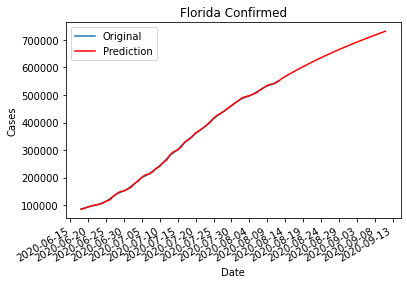

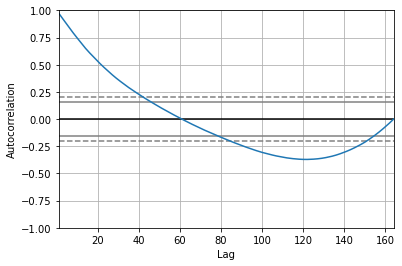

ARIMA(1, 0, 0) MSE=15435.514
ARIMA(1, 1, 0) MSE=3037.726
ARIMA(1, 1, 1) MSE=3115.652
ARIMA(1, 1, 2) MSE=2349.187
ARIMA(1, 2, 0) MSE=3100.574
ARIMA(1, 2, 1) MSE=2456.655
ARIMA(2, 0, 0) MSE=3034.140
ARIMA(2, 1, 0) MSE=3110.590
ARIMA(2, 1, 1) MSE=2563.719
ARIMA(2, 1, 2) MSE=2391.063
ARIMA(2, 2, 0) MSE=2724.251
ARIMA(2, 2, 1) MSE=2233.767
ARIMA(3, 1, 0) MSE=2869.503
ARIMA(3, 1, 1) MSE=2322.113
ARIMA(3, 1, 2) MSE=2700.823
ARIMA(3, 2, 0) MSE=2722.385
ARIMA(3, 2, 1) MSE=2292.275
ARIMA(4, 1, 0) MSE=2906.859
ARIMA(4, 1, 1) MSE=2407.637
ARIMA(4, 2, 0) MSE=2641.398
ARIMA(4, 2, 1) MSE=2197.302
ARIMA(4, 2, 2) MSE=1950.759
ARIMA(5, 1, 0) MSE=2776.703
ARIMA(5, 2, 0) MSE=2185.979
ARIMA(5, 2, 1) MSE=1922.263
ARIMA(6, 1, 0) MSE=2291.684
ARIMA(6, 2, 0) MSE=1514.075
ARIMA(7, 2, 0) MSE=1471.115
ARIMA(8, 2, 0) MSE=1521.033
ARIMA(9, 2, 0) MSE=1479.447
Best ARIMA(7, 2, 0) MSE=1471.115
predicted=3060.652676, expected=3061.000000
predicted=3098.699121, expected=3104.000000
predicted=3139.553105, expected=3144.0

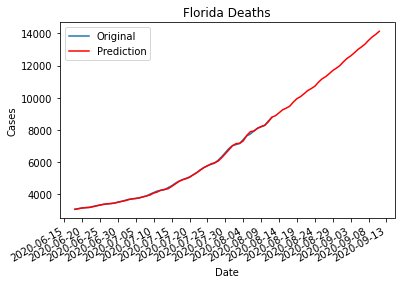

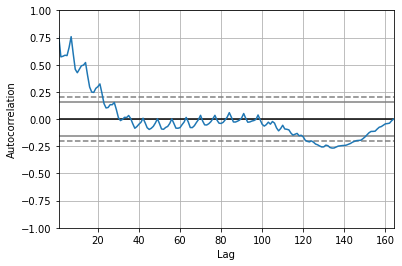

ARIMA(1, 0, 0) MSE=3035.165
ARIMA(1, 0, 1) MSE=3121.181
ARIMA(1, 0, 2) MSE=2349.213
ARIMA(1, 1, 0) MSE=3100.486
ARIMA(1, 1, 1) MSE=2457.138
ARIMA(1, 2, 0) MSE=6039.285
ARIMA(2, 0, 0) MSE=3108.996
ARIMA(2, 0, 1) MSE=2535.728
ARIMA(2, 0, 2) MSE=2438.787
ARIMA(2, 1, 0) MSE=2724.183
ARIMA(2, 1, 1) MSE=2234.275
ARIMA(2, 2, 0) MSE=4607.309
ARIMA(3, 0, 0) MSE=2867.515
ARIMA(3, 0, 1) MSE=2346.053
ARIMA(3, 0, 2) MSE=2501.858
ARIMA(3, 1, 0) MSE=2722.354
ARIMA(3, 1, 1) MSE=2292.791
ARIMA(3, 2, 0) MSE=4276.157
ARIMA(4, 0, 0) MSE=2904.614
ARIMA(4, 0, 1) MSE=2386.015
ARIMA(4, 1, 0) MSE=2641.464
ARIMA(4, 1, 1) MSE=2197.825
ARIMA(4, 1, 2) MSE=1957.627
ARIMA(4, 2, 0) MSE=4425.137
ARIMA(5, 0, 0) MSE=2774.890
ARIMA(5, 1, 0) MSE=2186.045
ARIMA(5, 1, 1) MSE=1922.657
ARIMA(5, 2, 0) MSE=4147.343
ARIMA(6, 0, 0) MSE=2286.144
ARIMA(6, 1, 0) MSE=1514.597
ARIMA(6, 2, 0) MSE=1872.785
ARIMA(7, 1, 0) MSE=1471.370
ARIMA(7, 2, 0) MSE=1750.499
ARIMA(8, 1, 0) MSE=1521.050
Best ARIMA(7, 1, 0) MSE=1471.370
predicted=42.64

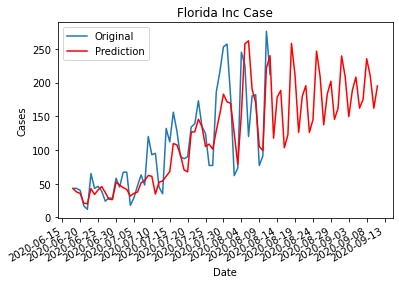

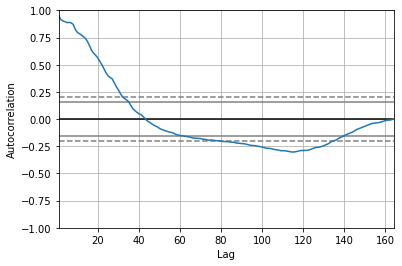

ARIMA(1, 0, 0) MSE=3887819.798
ARIMA(1, 1, 0) MSE=3919283.904
ARIMA(1, 1, 1) MSE=3899535.526
ARIMA(1, 2, 0) MSE=7065344.943
ARIMA(2, 0, 0) MSE=3962743.634
ARIMA(2, 1, 0) MSE=3968993.402
ARIMA(2, 2, 0) MSE=6738797.224
ARIMA(3, 0, 0) MSE=4038836.396
ARIMA(3, 1, 0) MSE=4089218.647
ARIMA(3, 1, 1) MSE=4026625.986
ARIMA(3, 2, 0) MSE=6220798.467
ARIMA(4, 0, 0) MSE=4113008.384
ARIMA(4, 1, 0) MSE=4259855.768
ARIMA(4, 1, 1) MSE=4192875.809
ARIMA(4, 2, 0) MSE=6246141.276
ARIMA(5, 0, 0) MSE=4300754.441
ARIMA(5, 1, 0) MSE=4094795.618
ARIMA(5, 2, 0) MSE=5832285.596
ARIMA(6, 0, 0) MSE=4158682.227
ARIMA(7, 0, 0) MSE=4461129.072
Best ARIMA(1, 0, 0) MSE=3887819.798
predicted=2260.611425, expected=3207.000000
predicted=2859.331911, expected=3822.000000
predicted=3538.016372, expected=4049.000000
predicted=3825.104676, expected=3494.000000
predicted=3271.616707, expected=2926.000000
predicted=2727.847278, expected=3286.000000
predicted=3088.604347, expected=5511.000000
predicted=5355.776377, expected=5004

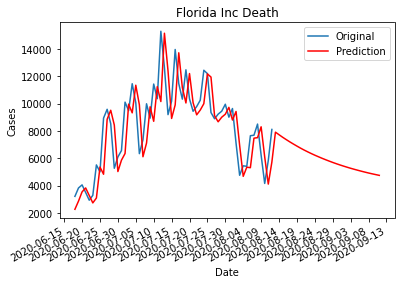

                      Confirmed     Deaths   Inc Case  Inc Death
US                          NaN        NaN        NaN        NaN
Alaska                      NaN        NaN        NaN        NaN
Alabama                     NaN        NaN        NaN        NaN
Arkansas                    NaN        NaN        NaN        NaN
Arizona               (1, 2, 1)  (6, 2, 0)  (6, 1, 0)  (1, 1, 1)
California            (6, 1, 0)  (9, 2, 0)  (9, 1, 0)  (6, 0, 0)
Colorado              (9, 1, 1)  (9, 0, 0)  (2, 1, 2)  (9, 0, 1)
Connecticut           (8, 0, 0)  (2, 2, 1)  (2, 1, 1)  (7, 1, 1)
District of Columbia  (7, 1, 0)  (1, 1, 1)  (1, 0, 1)  (6, 1, 0)
Delaware              (4, 1, 0)  (1, 1, 1)  (1, 0, 1)  (3, 0, 1)
Florida               (1, 1, 0)  (7, 2, 0)  (7, 1, 0)  (1, 0, 0)
Georgia                     NaN        NaN        NaN        NaN
Guam                        NaN        NaN        NaN        NaN
Hawaii                      NaN        NaN        NaN        NaN
Iowa                     

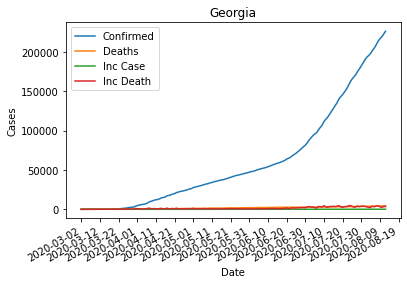

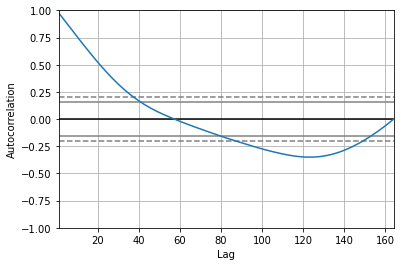

ARIMA(1, 0, 0) MSE=9775227.542
ARIMA(1, 1, 0) MSE=658124.371
ARIMA(1, 2, 0) MSE=602881.514
ARIMA(1, 2, 1) MSE=492057.591
ARIMA(2, 0, 0) MSE=633523.544
ARIMA(2, 1, 0) MSE=632927.827
ARIMA(2, 2, 0) MSE=517477.783
ARIMA(2, 2, 1) MSE=524683.486
ARIMA(3, 1, 0) MSE=531475.775
ARIMA(3, 2, 0) MSE=532519.510
ARIMA(3, 2, 1) MSE=509543.699
ARIMA(4, 1, 0) MSE=556905.407
ARIMA(4, 2, 0) MSE=442230.587
ARIMA(4, 2, 1) MSE=402827.705
ARIMA(5, 1, 0) MSE=459447.524
ARIMA(5, 2, 0) MSE=415901.041
ARIMA(5, 2, 1) MSE=404255.378
ARIMA(6, 1, 0) MSE=436738.447
ARIMA(6, 2, 0) MSE=397356.950
ARIMA(6, 2, 1) MSE=403768.215
ARIMA(7, 1, 0) MSE=425309.024
ARIMA(7, 2, 0) MSE=406381.434
ARIMA(7, 2, 1) MSE=387938.538
ARIMA(8, 1, 0) MSE=436090.555
ARIMA(8, 2, 0) MSE=403827.841
ARIMA(8, 2, 1) MSE=376181.044
ARIMA(9, 1, 0) MSE=425809.325
ARIMA(9, 2, 0) MSE=401616.474
ARIMA(9, 2, 1) MSE=380585.430
ARIMA(9, 2, 2) MSE=390039.973
Best ARIMA(8, 2, 1) MSE=376181.044
predicted=60936.702354, expected=60912.000000
predicted=61808.22

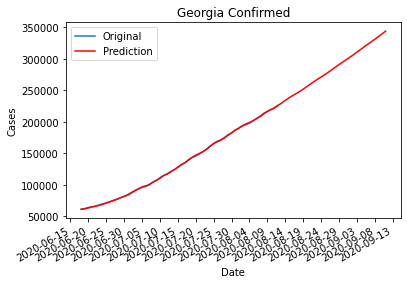

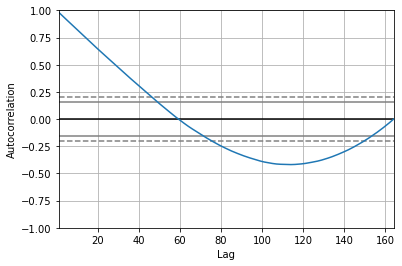

ARIMA(1, 0, 0) MSE=2042.411
ARIMA(1, 1, 0) MSE=815.564
ARIMA(1, 1, 1) MSE=754.800
ARIMA(1, 1, 2) MSE=728.217
ARIMA(1, 2, 0) MSE=1023.059
ARIMA(1, 2, 1) MSE=731.636
ARIMA(2, 1, 0) MSE=826.645
ARIMA(2, 1, 1) MSE=746.997
ARIMA(2, 1, 2) MSE=744.727
ARIMA(2, 2, 0) MSE=737.520
ARIMA(2, 2, 1) MSE=640.663
ARIMA(2, 2, 2) MSE=665.364
ARIMA(3, 1, 0) MSE=716.486
ARIMA(3, 1, 1) MSE=659.587
ARIMA(3, 2, 0) MSE=718.798
ARIMA(3, 2, 1) MSE=644.930
ARIMA(3, 2, 2) MSE=696.252
ARIMA(4, 1, 0) MSE=718.015
ARIMA(4, 1, 1) MSE=664.149
ARIMA(4, 2, 0) MSE=736.384
ARIMA(4, 2, 1) MSE=646.658
ARIMA(4, 2, 2) MSE=600.337
ARIMA(5, 0, 0) MSE=743.083
ARIMA(5, 1, 0) MSE=725.600
ARIMA(5, 1, 1) MSE=666.103
ARIMA(5, 2, 0) MSE=590.219
ARIMA(5, 2, 1) MSE=506.019
ARIMA(5, 2, 2) MSE=467.188
ARIMA(6, 0, 0) MSE=742.560
ARIMA(6, 1, 0) MSE=612.510
ARIMA(6, 1, 1) MSE=524.301
ARIMA(6, 1, 2) MSE=488.861
ARIMA(6, 2, 0) MSE=404.602
ARIMA(6, 2, 1) MSE=411.249
ARIMA(6, 2, 2) MSE=472.913
ARIMA(7, 0, 0) MSE=603.023
ARIMA(7, 1, 0) MSE=429.285

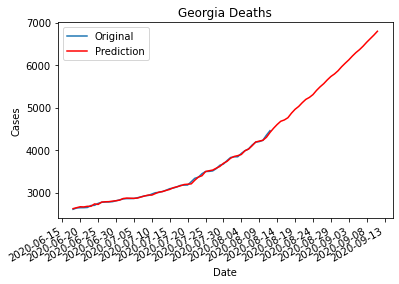

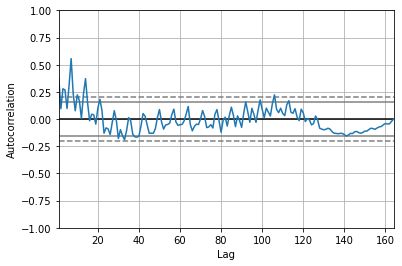

ARIMA(1, 0, 0) MSE=816.054
ARIMA(1, 0, 1) MSE=754.441
ARIMA(1, 0, 2) MSE=726.650
ARIMA(1, 1, 0) MSE=1023.020
ARIMA(1, 1, 1) MSE=731.609
ARIMA(1, 2, 0) MSE=2229.614
ARIMA(2, 0, 0) MSE=827.918
ARIMA(2, 0, 1) MSE=775.553
ARIMA(2, 0, 2) MSE=740.291
ARIMA(2, 1, 0) MSE=737.486
ARIMA(2, 1, 1) MSE=640.682
ARIMA(2, 1, 2) MSE=665.482
ARIMA(2, 2, 0) MSE=1354.138
ARIMA(3, 0, 0) MSE=716.328
ARIMA(3, 0, 1) MSE=659.293
ARIMA(3, 0, 2) MSE=687.173
ARIMA(3, 1, 0) MSE=718.768
ARIMA(3, 1, 1) MSE=644.940
ARIMA(3, 1, 2) MSE=696.498
ARIMA(3, 2, 0) MSE=1026.928
ARIMA(4, 0, 0) MSE=717.686
ARIMA(4, 0, 1) MSE=663.857
ARIMA(4, 1, 0) MSE=736.357
ARIMA(4, 1, 1) MSE=646.663
ARIMA(4, 1, 2) MSE=600.269
ARIMA(4, 2, 0) MSE=1056.373
ARIMA(5, 0, 0) MSE=725.548
ARIMA(5, 0, 1) MSE=665.865
ARIMA(5, 1, 0) MSE=590.198
ARIMA(5, 1, 1) MSE=505.993
ARIMA(5, 1, 2) MSE=467.084
ARIMA(5, 2, 0) MSE=1043.540
ARIMA(6, 0, 0) MSE=612.061
ARIMA(6, 0, 1) MSE=524.107
ARIMA(6, 1, 0) MSE=404.587
ARIMA(6, 1, 1) MSE=411.215
ARIMA(6, 1, 2) MSE=472

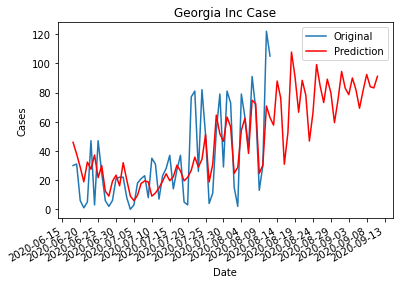

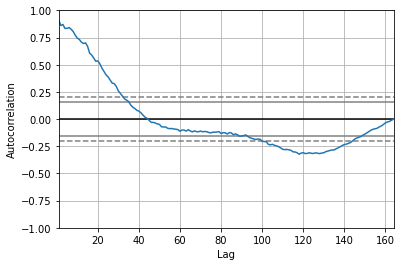

ARIMA(1, 0, 0) MSE=657015.012
ARIMA(1, 1, 0) MSE=602861.058
ARIMA(1, 1, 1) MSE=492128.361
ARIMA(1, 2, 0) MSE=1208701.146
ARIMA(2, 0, 0) MSE=632318.299
ARIMA(2, 1, 0) MSE=517472.412
ARIMA(2, 1, 1) MSE=524626.113
ARIMA(2, 2, 0) MSE=791846.416
ARIMA(3, 0, 0) MSE=530656.458
ARIMA(3, 1, 0) MSE=532517.534
ARIMA(3, 1, 1) MSE=508860.114
ARIMA(3, 2, 0) MSE=815990.742
ARIMA(4, 0, 0) MSE=542762.489
ARIMA(4, 1, 0) MSE=442256.226
ARIMA(4, 1, 1) MSE=402933.274
ARIMA(4, 2, 0) MSE=749047.528
ARIMA(5, 0, 0) MSE=458540.739
ARIMA(5, 1, 0) MSE=415970.322
ARIMA(5, 1, 1) MSE=404370.971
ARIMA(5, 2, 0) MSE=694818.186
ARIMA(6, 0, 0) MSE=436538.092
ARIMA(6, 1, 0) MSE=397483.287
ARIMA(6, 1, 1) MSE=403877.245
ARIMA(6, 2, 0) MSE=592798.111
ARIMA(7, 0, 0) MSE=425118.381
ARIMA(7, 1, 0) MSE=406537.099
ARIMA(7, 1, 1) MSE=387987.441
ARIMA(7, 2, 0) MSE=486241.103
ARIMA(8, 0, 0) MSE=436696.618
ARIMA(8, 1, 0) MSE=403934.342
ARIMA(8, 1, 1) MSE=376201.849
ARIMA(9, 0, 0) MSE=423141.085
ARIMA(9, 1, 0) MSE=401683.131
ARIMA(9, 

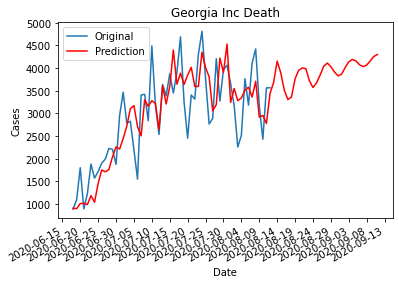

                      Confirmed     Deaths   Inc Case  Inc Death
US                          NaN        NaN        NaN        NaN
Alaska                      NaN        NaN        NaN        NaN
Alabama                     NaN        NaN        NaN        NaN
Arkansas                    NaN        NaN        NaN        NaN
Arizona               (1, 2, 1)  (6, 2, 0)  (6, 1, 0)  (1, 1, 1)
California            (6, 1, 0)  (9, 2, 0)  (9, 1, 0)  (6, 0, 0)
Colorado              (9, 1, 1)  (9, 0, 0)  (2, 1, 2)  (9, 0, 1)
Connecticut           (8, 0, 0)  (2, 2, 1)  (2, 1, 1)  (7, 1, 1)
District of Columbia  (7, 1, 0)  (1, 1, 1)  (1, 0, 1)  (6, 1, 0)
Delaware              (4, 1, 0)  (1, 1, 1)  (1, 0, 1)  (3, 0, 1)
Florida               (1, 1, 0)  (7, 2, 0)  (7, 1, 0)  (1, 0, 0)
Georgia               (8, 2, 1)  (6, 2, 0)  (6, 1, 0)  (8, 1, 1)
Guam                        NaN        NaN        NaN        NaN
Hawaii                      NaN        NaN        NaN        NaN
Iowa                     

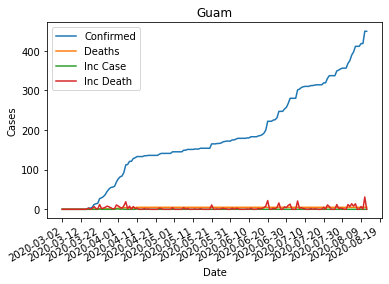

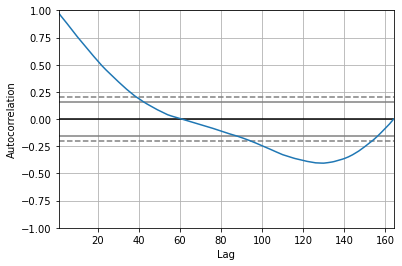

ARIMA(1, 0, 0) MSE=65.835
ARIMA(1, 1, 0) MSE=51.320
ARIMA(1, 2, 0) MSE=67.579
ARIMA(1, 2, 1) MSE=50.758
ARIMA(1, 2, 2) MSE=51.612
ARIMA(2, 1, 0) MSE=51.307
ARIMA(2, 2, 0) MSE=64.398
ARIMA(2, 2, 1) MSE=51.151
ARIMA(2, 2, 2) MSE=52.049
ARIMA(3, 0, 0) MSE=57.678
ARIMA(3, 1, 0) MSE=51.994
ARIMA(3, 2, 0) MSE=61.822
ARIMA(3, 2, 1) MSE=51.507
ARIMA(3, 2, 2) MSE=52.915
ARIMA(4, 0, 0) MSE=58.257
ARIMA(4, 1, 0) MSE=53.470
ARIMA(4, 1, 1) MSE=50.835
ARIMA(4, 2, 0) MSE=55.375
ARIMA(4, 2, 1) MSE=51.099
ARIMA(4, 2, 2) MSE=52.822
ARIMA(5, 1, 0) MSE=51.569
ARIMA(5, 1, 1) MSE=50.307
ARIMA(5, 1, 2) MSE=52.876
ARIMA(5, 2, 0) MSE=52.874
ARIMA(5, 2, 1) MSE=53.772
ARIMA(5, 2, 2) MSE=54.110
ARIMA(6, 0, 0) MSE=54.341
ARIMA(6, 1, 0) MSE=50.997
ARIMA(6, 1, 1) MSE=50.904
ARIMA(6, 1, 2) MSE=51.965
ARIMA(6, 2, 0) MSE=52.270
ARIMA(6, 2, 1) MSE=53.416
ARIMA(6, 2, 2) MSE=54.820
ARIMA(7, 0, 0) MSE=53.686
ARIMA(7, 1, 0) MSE=51.382
ARIMA(7, 1, 1) MSE=50.827
ARIMA(7, 1, 2) MSE=53.096
ARIMA(7, 2, 0) MSE=52.824
ARIMA(7, 2, 

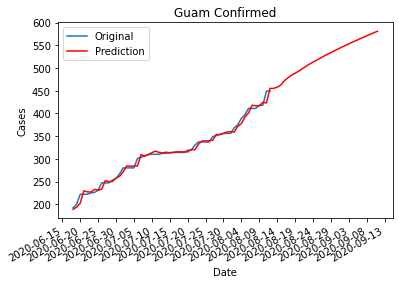

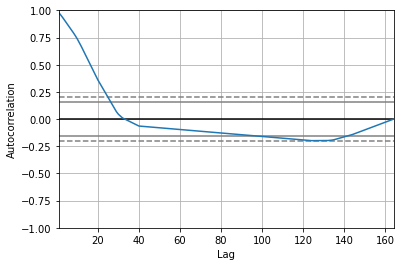

ARIMA(1, 0, 0) MSE=0.000
ARIMA(1, 0, 1) MSE=0.000
ARIMA(1, 0, 2) MSE=0.000
ARIMA(1, 1, 0) MSE=0.001
ARIMA(1, 1, 1) MSE=0.001
ARIMA(1, 1, 2) MSE=0.001
ARIMA(1, 2, 0) MSE=0.000
ARIMA(1, 2, 1) MSE=0.000
ARIMA(1, 2, 2) MSE=0.000
ARIMA(2, 0, 0) MSE=0.000
ARIMA(2, 0, 1) MSE=0.003
ARIMA(2, 0, 2) MSE=0.000
ARIMA(2, 1, 0) MSE=0.001
ARIMA(2, 1, 1) MSE=0.001
ARIMA(2, 1, 2) MSE=0.001
ARIMA(2, 2, 0) MSE=0.000
ARIMA(2, 2, 1) MSE=0.000
ARIMA(2, 2, 2) MSE=0.000
ARIMA(3, 0, 0) MSE=0.000
ARIMA(3, 0, 1) MSE=0.000
ARIMA(3, 0, 2) MSE=0.003
ARIMA(3, 1, 0) MSE=0.001
ARIMA(3, 1, 1) MSE=0.001
ARIMA(3, 1, 2) MSE=0.001
ARIMA(3, 2, 0) MSE=0.000
ARIMA(3, 2, 2) MSE=0.000
ARIMA(4, 0, 0) MSE=0.000
ARIMA(4, 0, 1) MSE=0.000
ARIMA(4, 0, 2) MSE=0.000
ARIMA(4, 1, 0) MSE=0.001
ARIMA(4, 1, 1) MSE=0.001
ARIMA(4, 1, 2) MSE=0.002
ARIMA(4, 2, 0) MSE=0.000
ARIMA(4, 2, 1) MSE=0.000
ARIMA(4, 2, 2) MSE=0.000
ARIMA(5, 0, 0) MSE=0.000
ARIMA(5, 0, 1) MSE=0.000
ARIMA(5, 1, 0) MSE=0.001
ARIMA(5, 1, 1) MSE=0.001
ARIMA(5, 1, 2) MSE=0.001


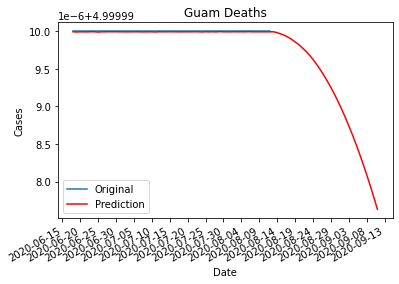

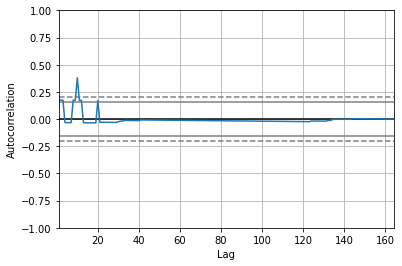

ARIMA(1, 0, 0) MSE=0.001
ARIMA(1, 0, 1) MSE=0.001
ARIMA(1, 0, 2) MSE=0.001
ARIMA(1, 1, 0) MSE=0.000
ARIMA(1, 1, 1) MSE=0.000
ARIMA(1, 1, 2) MSE=0.000
ARIMA(1, 2, 0) MSE=0.000
ARIMA(2, 0, 0) MSE=0.001
ARIMA(2, 0, 1) MSE=0.001
ARIMA(2, 0, 2) MSE=0.002
ARIMA(2, 1, 0) MSE=0.000
ARIMA(2, 1, 1) MSE=0.000
ARIMA(2, 1, 2) MSE=0.000
ARIMA(2, 2, 0) MSE=0.000
ARIMA(3, 0, 0) MSE=0.001
ARIMA(3, 0, 1) MSE=0.001
ARIMA(3, 0, 2) MSE=0.001
ARIMA(3, 1, 0) MSE=0.000
ARIMA(3, 1, 1) MSE=0.000
ARIMA(3, 1, 2) MSE=0.000
ARIMA(3, 2, 0) MSE=0.000
ARIMA(3, 2, 1) MSE=0.000
ARIMA(4, 0, 0) MSE=0.001
ARIMA(4, 0, 1) MSE=0.001
ARIMA(4, 0, 2) MSE=0.001
ARIMA(4, 1, 0) MSE=0.000
ARIMA(4, 1, 1) MSE=0.000
ARIMA(4, 1, 2) MSE=0.000
ARIMA(4, 2, 0) MSE=0.000
ARIMA(5, 0, 0) MSE=0.001
ARIMA(5, 0, 1) MSE=0.001
ARIMA(5, 0, 2) MSE=0.001
ARIMA(5, 1, 0) MSE=0.000
ARIMA(5, 1, 1) MSE=0.000
ARIMA(5, 1, 2) MSE=0.000
ARIMA(5, 2, 0) MSE=0.000
ARIMA(6, 0, 0) MSE=0.001
ARIMA(6, 0, 1) MSE=0.001
ARIMA(6, 0, 2) MSE=0.001
ARIMA(6, 1, 0) MSE=0.000


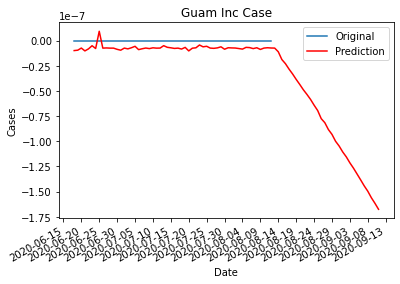

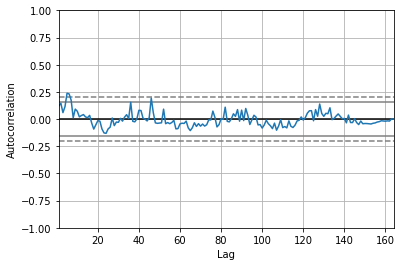

ARIMA(1, 0, 0) MSE=51.399
ARIMA(1, 1, 0) MSE=67.575
ARIMA(1, 1, 1) MSE=50.750
ARIMA(1, 1, 2) MSE=51.601
ARIMA(1, 2, 0) MSE=139.991
ARIMA(2, 0, 0) MSE=51.368
ARIMA(2, 1, 0) MSE=64.394
ARIMA(2, 1, 1) MSE=51.150
ARIMA(2, 1, 2) MSE=52.045
ARIMA(2, 2, 0) MSE=115.056
ARIMA(3, 0, 0) MSE=52.056
ARIMA(3, 1, 0) MSE=61.819
ARIMA(3, 1, 1) MSE=51.503
ARIMA(3, 1, 2) MSE=52.914
ARIMA(3, 2, 0) MSE=107.816
ARIMA(4, 0, 0) MSE=53.525
ARIMA(4, 0, 1) MSE=50.851
ARIMA(4, 1, 0) MSE=55.372
ARIMA(4, 1, 1) MSE=51.096
ARIMA(4, 1, 2) MSE=52.821
ARIMA(4, 2, 0) MSE=96.470
ARIMA(5, 0, 0) MSE=51.600
ARIMA(5, 0, 1) MSE=50.324
ARIMA(5, 0, 2) MSE=52.904
ARIMA(5, 1, 0) MSE=52.871
ARIMA(5, 1, 1) MSE=53.764
ARIMA(5, 1, 2) MSE=54.097
ARIMA(5, 2, 0) MSE=86.478
ARIMA(6, 0, 0) MSE=51.017
ARIMA(6, 0, 2) MSE=51.992
ARIMA(6, 1, 0) MSE=52.267
ARIMA(6, 1, 1) MSE=53.365
ARIMA(6, 1, 2) MSE=54.765
ARIMA(6, 2, 0) MSE=71.842
ARIMA(7, 0, 0) MSE=51.395
ARIMA(7, 1, 0) MSE=52.822
ARIMA(7, 1, 1) MSE=53.526
ARIMA(8, 0, 0) MSE=51.579
ARIMA(8, 

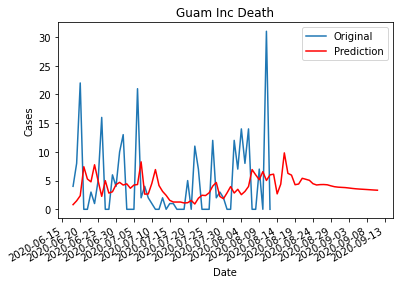

                      Confirmed     Deaths   Inc Case  Inc Death
US                          NaN        NaN        NaN        NaN
Alaska                      NaN        NaN        NaN        NaN
Alabama                     NaN        NaN        NaN        NaN
Arkansas                    NaN        NaN        NaN        NaN
Arizona               (1, 2, 1)  (6, 2, 0)  (6, 1, 0)  (1, 1, 1)
California            (6, 1, 0)  (9, 2, 0)  (9, 1, 0)  (6, 0, 0)
Colorado              (9, 1, 1)  (9, 0, 0)  (2, 1, 2)  (9, 0, 1)
Connecticut           (8, 0, 0)  (2, 2, 1)  (2, 1, 1)  (7, 1, 1)
District of Columbia  (7, 1, 0)  (1, 1, 1)  (1, 0, 1)  (6, 1, 0)
Delaware              (4, 1, 0)  (1, 1, 1)  (1, 0, 1)  (3, 0, 1)
Florida               (1, 1, 0)  (7, 2, 0)  (7, 1, 0)  (1, 0, 0)
Georgia               (8, 2, 1)  (6, 2, 0)  (6, 1, 0)  (8, 1, 1)
Guam                  (5, 1, 1)  (1, 2, 0)  (1, 1, 0)  (5, 0, 1)
Hawaii                      NaN        NaN        NaN        NaN
Iowa                     

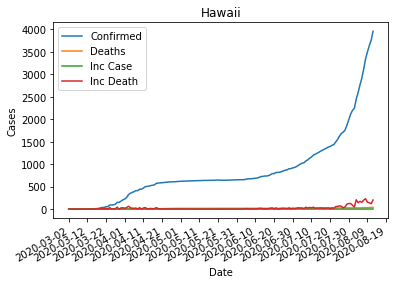

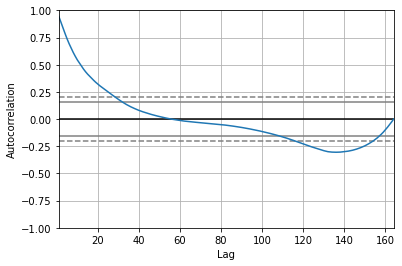

ARIMA(1, 0, 0) MSE=7042.656
ARIMA(1, 1, 0) MSE=1301.902
ARIMA(1, 2, 0) MSE=1052.512
ARIMA(1, 2, 1) MSE=1022.135
ARIMA(1, 2, 2) MSE=1179.104
ARIMA(2, 0, 0) MSE=1290.121
ARIMA(2, 1, 0) MSE=1141.046
ARIMA(2, 2, 0) MSE=1110.106
ARIMA(2, 2, 1) MSE=1072.176
ARIMA(2, 2, 2) MSE=1089.464
ARIMA(3, 1, 0) MSE=1218.154
ARIMA(3, 2, 0) MSE=985.813
ARIMA(3, 2, 1) MSE=1027.629
ARIMA(4, 1, 0) MSE=1072.288
ARIMA(4, 2, 0) MSE=987.375
ARIMA(4, 2, 1) MSE=1071.747
ARIMA(4, 2, 2) MSE=2791.821
ARIMA(5, 1, 0) MSE=1055.469
ARIMA(5, 2, 0) MSE=1070.546
ARIMA(5, 2, 1) MSE=1046.470
ARIMA(6, 1, 0) MSE=1115.229
ARIMA(6, 2, 0) MSE=1173.930
ARIMA(7, 1, 0) MSE=1222.245
ARIMA(7, 2, 0) MSE=1236.462
ARIMA(8, 2, 0) MSE=1304.199
ARIMA(9, 2, 0) MSE=1241.776
Best ARIMA(3, 2, 0) MSE=985.813
predicted=749.096465, expected=762.000000
predicted=769.856761, expected=789.000000
predicted=802.256369, expected=789.000000
predicted=803.569447, expected=814.000000
predicted=831.019260, expected=816.000000
predicted=831.575678, expected=8

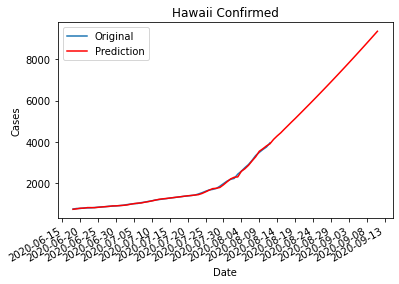

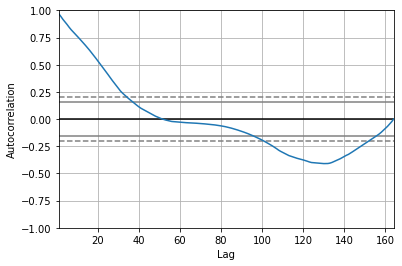

ARIMA(1, 0, 0) MSE=0.884
ARIMA(1, 1, 0) MSE=0.776
ARIMA(1, 1, 1) MSE=0.729
ARIMA(1, 1, 2) MSE=0.709
ARIMA(1, 2, 0) MSE=0.879
ARIMA(1, 2, 1) MSE=0.701
ARIMA(1, 2, 2) MSE=0.712
ARIMA(2, 0, 0) MSE=0.870
ARIMA(2, 1, 0) MSE=0.768
ARIMA(2, 1, 1) MSE=0.716
ARIMA(2, 1, 2) MSE=0.721
ARIMA(2, 2, 0) MSE=0.813
ARIMA(2, 2, 1) MSE=0.721
ARIMA(3, 0, 0) MSE=0.818
ARIMA(3, 1, 0) MSE=0.777
ARIMA(3, 1, 1) MSE=0.756
ARIMA(3, 1, 2) MSE=0.741
ARIMA(3, 2, 0) MSE=0.779
ARIMA(3, 2, 1) MSE=0.742
ARIMA(4, 0, 0) MSE=0.813
ARIMA(4, 1, 0) MSE=0.783
ARIMA(4, 1, 1) MSE=0.760
ARIMA(4, 1, 2) MSE=0.738
ARIMA(4, 2, 0) MSE=0.727
ARIMA(4, 2, 1) MSE=0.777
ARIMA(5, 0, 0) MSE=0.809
ARIMA(5, 1, 0) MSE=0.758
ARIMA(5, 1, 1) MSE=0.753
ARIMA(5, 2, 0) MSE=0.689
ARIMA(5, 2, 1) MSE=0.688
ARIMA(6, 0, 0) MSE=0.773
ARIMA(6, 1, 0) MSE=0.736
ARIMA(6, 1, 1) MSE=0.713
ARIMA(6, 1, 2) MSE=0.737
ARIMA(6, 2, 0) MSE=0.684
ARIMA(6, 2, 1) MSE=0.725
ARIMA(7, 0, 0) MSE=0.745
ARIMA(7, 1, 0) MSE=0.715
ARIMA(7, 1, 1) MSE=0.718
ARIMA(7, 1, 2) MSE=0.717


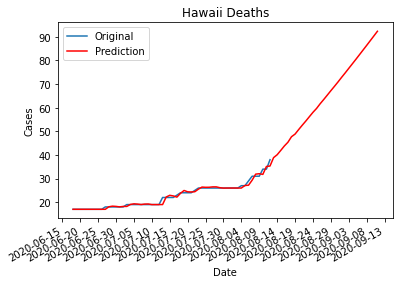

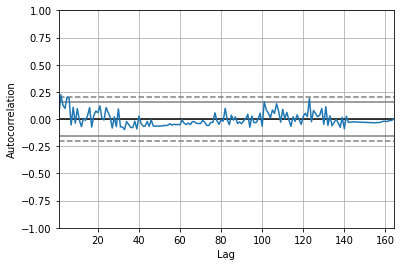

ARIMA(1, 0, 0) MSE=0.777
ARIMA(1, 0, 1) MSE=0.729
ARIMA(1, 0, 2) MSE=0.709
ARIMA(1, 1, 0) MSE=0.879
ARIMA(1, 1, 1) MSE=0.702
ARIMA(1, 1, 2) MSE=0.711
ARIMA(1, 2, 0) MSE=1.947
ARIMA(2, 0, 0) MSE=0.768
ARIMA(2, 0, 1) MSE=0.716
ARIMA(2, 0, 2) MSE=0.722
ARIMA(2, 1, 0) MSE=0.813
ARIMA(2, 1, 1) MSE=0.721
ARIMA(2, 2, 0) MSE=1.457
ARIMA(3, 0, 0) MSE=0.777
ARIMA(3, 0, 1) MSE=0.756
ARIMA(3, 0, 2) MSE=0.740
ARIMA(3, 1, 0) MSE=0.779
ARIMA(3, 1, 1) MSE=0.742
ARIMA(3, 2, 0) MSE=1.285
ARIMA(4, 0, 0) MSE=0.783
ARIMA(4, 0, 1) MSE=0.760
ARIMA(4, 0, 2) MSE=0.738
ARIMA(4, 1, 0) MSE=0.727
ARIMA(4, 1, 1) MSE=0.777
ARIMA(4, 2, 0) MSE=1.175
ARIMA(4, 2, 1) MSE=0.735
ARIMA(5, 0, 0) MSE=0.758
ARIMA(5, 0, 1) MSE=0.753
ARIMA(5, 0, 2) MSE=0.733
ARIMA(5, 1, 0) MSE=0.689
ARIMA(5, 1, 1) MSE=0.688
ARIMA(5, 2, 0) MSE=0.881
ARIMA(6, 0, 0) MSE=0.736
ARIMA(6, 0, 1) MSE=0.713
ARIMA(6, 0, 2) MSE=0.730
ARIMA(6, 1, 0) MSE=0.684
ARIMA(6, 1, 1) MSE=0.724
ARIMA(6, 2, 0) MSE=0.844
ARIMA(7, 0, 0) MSE=0.715
ARIMA(7, 0, 1) MSE=0.717


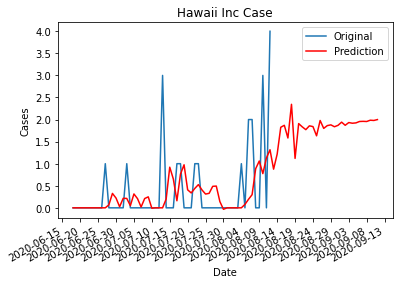

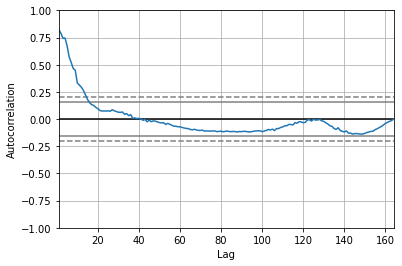

ARIMA(1, 0, 0) MSE=1301.623
ARIMA(1, 1, 0) MSE=1052.518
ARIMA(1, 1, 1) MSE=1022.260
ARIMA(1, 1, 2) MSE=1179.314
ARIMA(1, 2, 0) MSE=1965.219
ARIMA(2, 0, 0) MSE=1140.786
ARIMA(2, 1, 0) MSE=1110.140
ARIMA(2, 1, 1) MSE=1072.337
ARIMA(2, 1, 2) MSE=1089.300
ARIMA(2, 2, 0) MSE=1874.735
ARIMA(3, 0, 0) MSE=1215.956
ARIMA(3, 1, 0) MSE=985.911
ARIMA(3, 1, 1) MSE=1027.789
ARIMA(3, 2, 0) MSE=1614.524
ARIMA(4, 0, 0) MSE=1071.220
ARIMA(4, 1, 0) MSE=987.531
ARIMA(4, 1, 1) MSE=1066.093
ARIMA(4, 2, 0) MSE=1201.241
ARIMA(5, 0, 0) MSE=1063.863
ARIMA(5, 1, 0) MSE=1070.698
ARIMA(5, 1, 1) MSE=1046.618
ARIMA(5, 2, 0) MSE=1237.861
ARIMA(6, 0, 0) MSE=1116.301
ARIMA(6, 1, 0) MSE=1174.208
ARIMA(6, 2, 0) MSE=1281.126
ARIMA(7, 0, 0) MSE=1250.820
ARIMA(7, 1, 0) MSE=1236.672
ARIMA(8, 1, 0) MSE=1304.535
ARIMA(9, 1, 0) MSE=1242.093
Best ARIMA(3, 1, 0) MSE=985.911
predicted=5.095203, expected=18.000000
predicted=7.853478, expected=27.000000
predicted=13.250566, expected=0.000000
predicted=14.566743, expected=25.000000
p

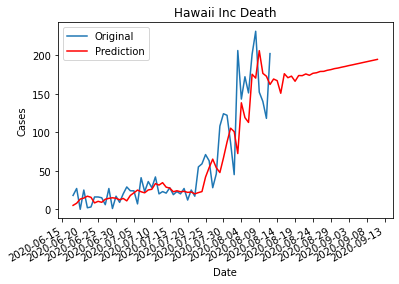

                      Confirmed     Deaths   Inc Case  Inc Death
US                          NaN        NaN        NaN        NaN
Alaska                      NaN        NaN        NaN        NaN
Alabama                     NaN        NaN        NaN        NaN
Arkansas                    NaN        NaN        NaN        NaN
Arizona               (1, 2, 1)  (6, 2, 0)  (6, 1, 0)  (1, 1, 1)
California            (6, 1, 0)  (9, 2, 0)  (9, 1, 0)  (6, 0, 0)
Colorado              (9, 1, 1)  (9, 0, 0)  (2, 1, 2)  (9, 0, 1)
Connecticut           (8, 0, 0)  (2, 2, 1)  (2, 1, 1)  (7, 1, 1)
District of Columbia  (7, 1, 0)  (1, 1, 1)  (1, 0, 1)  (6, 1, 0)
Delaware              (4, 1, 0)  (1, 1, 1)  (1, 0, 1)  (3, 0, 1)
Florida               (1, 1, 0)  (7, 2, 0)  (7, 1, 0)  (1, 0, 0)
Georgia               (8, 2, 1)  (6, 2, 0)  (6, 1, 0)  (8, 1, 1)
Guam                  (5, 1, 1)  (1, 2, 0)  (1, 1, 0)  (5, 0, 1)
Hawaii                (3, 2, 0)  (6, 2, 0)  (6, 1, 0)  (3, 1, 0)
Iowa                     

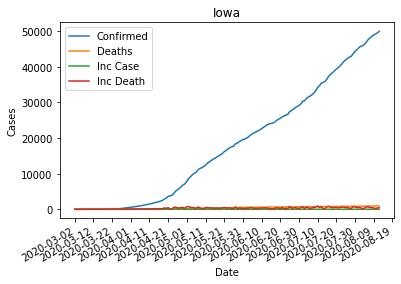

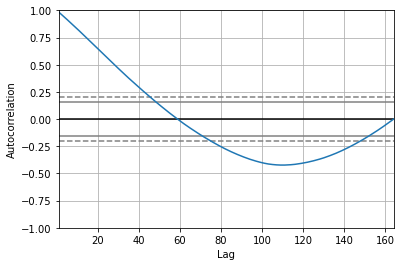

ARIMA(1, 0, 0) MSE=240466.630
ARIMA(1, 1, 0) MSE=46767.751
ARIMA(1, 1, 1) MSE=36208.141
ARIMA(1, 1, 2) MSE=36615.569
ARIMA(1, 2, 0) MSE=49046.583
ARIMA(1, 2, 1) MSE=36054.950
ARIMA(1, 2, 2) MSE=36906.608
ARIMA(2, 0, 0) MSE=54573.174
ARIMA(2, 1, 0) MSE=44626.082
ARIMA(2, 1, 1) MSE=36598.140
ARIMA(2, 2, 0) MSE=46002.421
ARIMA(2, 2, 1) MSE=36109.365
ARIMA(2, 2, 2) MSE=34637.113
ARIMA(3, 1, 0) MSE=43596.132
ARIMA(3, 1, 1) MSE=36662.114
ARIMA(3, 2, 0) MSE=44744.039
ARIMA(3, 2, 1) MSE=36080.183
ARIMA(3, 2, 2) MSE=34165.128
ARIMA(4, 1, 0) MSE=43475.591
ARIMA(4, 1, 1) MSE=36669.866
ARIMA(4, 1, 2) MSE=34520.144
ARIMA(4, 2, 0) MSE=43559.025
ARIMA(4, 2, 1) MSE=35334.781
ARIMA(5, 1, 0) MSE=42856.653
ARIMA(5, 1, 1) MSE=35924.196
ARIMA(5, 2, 0) MSE=34670.480
ARIMA(5, 2, 1) MSE=30907.403
ARIMA(5, 2, 2) MSE=27290.602
ARIMA(6, 1, 0) MSE=34715.418
ARIMA(6, 1, 1) MSE=31516.733
ARIMA(6, 2, 0) MSE=30893.518
ARIMA(6, 2, 1) MSE=30890.714
ARIMA(6, 2, 2) MSE=28815.735
ARIMA(7, 1, 0) MSE=31416.802
ARIMA(7, 1, 1

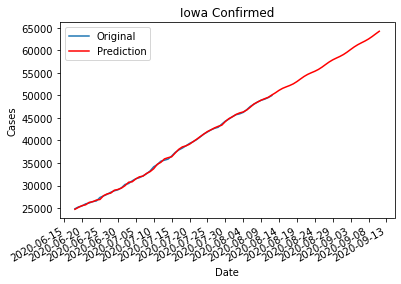

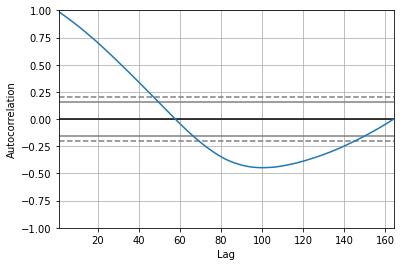

ARIMA(1, 0, 0) MSE=41.175
ARIMA(1, 1, 0) MSE=19.556
ARIMA(1, 1, 1) MSE=16.763
ARIMA(1, 1, 2) MSE=16.882
ARIMA(1, 2, 0) MSE=23.391
ARIMA(1, 2, 1) MSE=17.244
ARIMA(1, 2, 2) MSE=15.612
ARIMA(2, 0, 0) MSE=24.517
ARIMA(2, 1, 0) MSE=19.333
ARIMA(2, 1, 1) MSE=16.855
ARIMA(2, 2, 0) MSE=20.730
ARIMA(2, 2, 1) MSE=17.090
ARIMA(2, 2, 2) MSE=17.046
ARIMA(3, 1, 0) MSE=18.744
ARIMA(3, 1, 1) MSE=16.734
ARIMA(3, 2, 0) MSE=20.480
ARIMA(4, 0, 0) MSE=20.137
ARIMA(4, 1, 0) MSE=18.773
ARIMA(4, 2, 0) MSE=19.334
ARIMA(4, 2, 1) MSE=16.097
ARIMA(4, 2, 2) MSE=14.876
ARIMA(5, 0, 0) MSE=19.996
ARIMA(5, 1, 0) MSE=18.250
ARIMA(5, 1, 1) MSE=15.860
ARIMA(5, 1, 2) MSE=14.671
ARIMA(5, 2, 0) MSE=17.284
ARIMA(5, 2, 1) MSE=15.349
ARIMA(5, 2, 2) MSE=14.615
ARIMA(6, 0, 0) MSE=18.928
ARIMA(6, 1, 0) MSE=16.769
ARIMA(6, 1, 1) MSE=15.141
ARIMA(6, 1, 2) MSE=14.370
ARIMA(6, 2, 0) MSE=16.074
ARIMA(6, 2, 1) MSE=15.157
ARIMA(6, 2, 2) MSE=15.255
ARIMA(7, 1, 0) MSE=15.757
ARIMA(7, 1, 1) MSE=14.966
ARIMA(7, 2, 0) MSE=14.474
ARIMA(7, 2, 

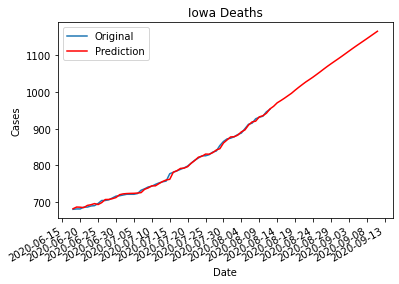

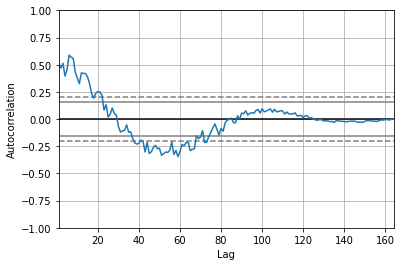

ARIMA(1, 0, 0) MSE=19.582
ARIMA(1, 0, 1) MSE=16.764
ARIMA(1, 0, 2) MSE=16.883
ARIMA(1, 1, 0) MSE=23.390
ARIMA(1, 1, 1) MSE=17.241
ARIMA(1, 1, 2) MSE=15.115
ARIMA(1, 2, 0) MSE=51.281
ARIMA(2, 0, 0) MSE=19.353
ARIMA(2, 0, 1) MSE=16.856
ARIMA(2, 1, 0) MSE=20.728
ARIMA(2, 1, 1) MSE=17.087
ARIMA(2, 1, 2) MSE=16.738
ARIMA(2, 2, 0) MSE=37.010
ARIMA(3, 0, 0) MSE=18.756
ARIMA(3, 0, 1) MSE=16.735
ARIMA(3, 1, 0) MSE=20.479
ARIMA(3, 2, 0) MSE=33.734
ARIMA(4, 0, 0) MSE=18.784
ARIMA(4, 1, 0) MSE=19.332
ARIMA(4, 1, 1) MSE=16.095
ARIMA(4, 1, 2) MSE=14.875
ARIMA(4, 2, 0) MSE=32.252
ARIMA(5, 0, 0) MSE=18.257
ARIMA(5, 0, 1) MSE=15.861
ARIMA(5, 0, 2) MSE=14.673
ARIMA(5, 1, 0) MSE=17.283
ARIMA(5, 1, 1) MSE=15.347
ARIMA(5, 1, 2) MSE=14.614
ARIMA(5, 2, 0) MSE=29.090
ARIMA(6, 0, 0) MSE=16.772
ARIMA(6, 0, 1) MSE=15.142
ARIMA(6, 0, 2) MSE=14.371
ARIMA(6, 1, 0) MSE=16.073
ARIMA(6, 1, 1) MSE=15.155
ARIMA(6, 1, 2) MSE=15.253
ARIMA(6, 2, 0) MSE=27.824
ARIMA(6, 2, 1) MSE=16.941
ARIMA(7, 0, 0) MSE=15.759
ARIMA(7, 0, 

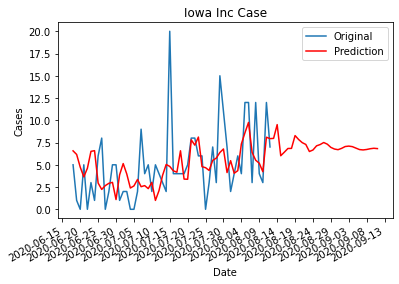

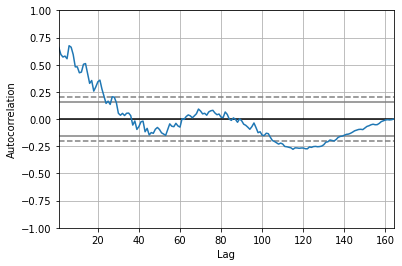

ARIMA(1, 0, 0) MSE=46896.514
ARIMA(1, 0, 1) MSE=36205.617
ARIMA(1, 0, 2) MSE=36612.961
ARIMA(1, 1, 0) MSE=49044.002
ARIMA(1, 1, 1) MSE=36053.799
ARIMA(1, 1, 2) MSE=36825.062
ARIMA(1, 2, 0) MSE=101275.144
ARIMA(2, 0, 0) MSE=44693.529
ARIMA(2, 0, 1) MSE=36595.465
ARIMA(2, 1, 0) MSE=45999.835
ARIMA(2, 1, 1) MSE=36108.409
ARIMA(2, 1, 2) MSE=34638.201
ARIMA(2, 2, 0) MSE=81792.790
ARIMA(3, 0, 0) MSE=43636.609
ARIMA(3, 0, 1) MSE=36658.976
ARIMA(3, 1, 0) MSE=44742.075
ARIMA(3, 1, 1) MSE=36079.653
ARIMA(3, 1, 2) MSE=34165.605
ARIMA(3, 2, 0) MSE=73667.679
ARIMA(4, 0, 0) MSE=43499.047
ARIMA(4, 0, 1) MSE=36667.165
ARIMA(4, 0, 2) MSE=34519.645
ARIMA(4, 1, 0) MSE=43557.005
ARIMA(4, 1, 1) MSE=35334.002
ARIMA(4, 2, 0) MSE=73597.743
ARIMA(5, 0, 0) MSE=42871.314
ARIMA(5, 0, 1) MSE=35920.806
ARIMA(5, 1, 0) MSE=34668.964
ARIMA(5, 1, 1) MSE=30906.737
ARIMA(5, 1, 2) MSE=27287.184
ARIMA(5, 2, 0) MSE=66894.489
ARIMA(6, 0, 0) MSE=34716.396
ARIMA(6, 0, 1) MSE=31513.757
ARIMA(6, 1, 0) MSE=30892.560
ARIMA(6, 1, 1

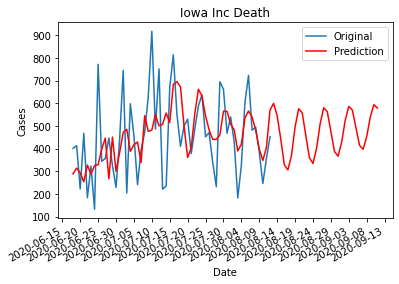

                      Confirmed     Deaths   Inc Case  Inc Death
US                          NaN        NaN        NaN        NaN
Alaska                      NaN        NaN        NaN        NaN
Alabama                     NaN        NaN        NaN        NaN
Arkansas                    NaN        NaN        NaN        NaN
Arizona               (1, 2, 1)  (6, 2, 0)  (6, 1, 0)  (1, 1, 1)
California            (6, 1, 0)  (9, 2, 0)  (9, 1, 0)  (6, 0, 0)
Colorado              (9, 1, 1)  (9, 0, 0)  (2, 1, 2)  (9, 0, 1)
Connecticut           (8, 0, 0)  (2, 2, 1)  (2, 1, 1)  (7, 1, 1)
District of Columbia  (7, 1, 0)  (1, 1, 1)  (1, 0, 1)  (6, 1, 0)
Delaware              (4, 1, 0)  (1, 1, 1)  (1, 0, 1)  (3, 0, 1)
Florida               (1, 1, 0)  (7, 2, 0)  (7, 1, 0)  (1, 0, 0)
Georgia               (8, 2, 1)  (6, 2, 0)  (6, 1, 0)  (8, 1, 1)
Guam                  (5, 1, 1)  (1, 2, 0)  (1, 1, 0)  (5, 0, 1)
Hawaii                (3, 2, 0)  (6, 2, 0)  (6, 1, 0)  (3, 1, 0)
Iowa                  (5,

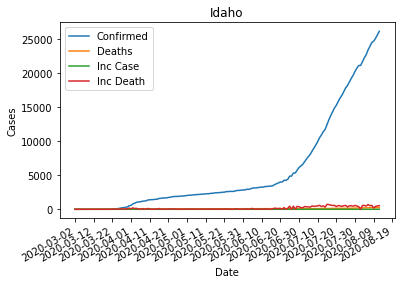

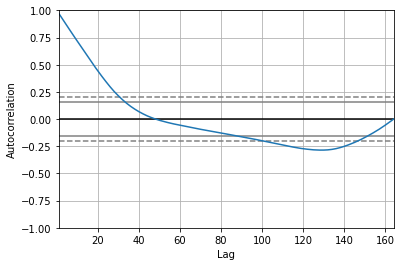

ARIMA(1, 0, 0) MSE=196999.626
ARIMA(1, 1, 0) MSE=42876.600
ARIMA(1, 2, 0) MSE=28242.430
ARIMA(1, 2, 1) MSE=23839.507
ARIMA(1, 2, 2) MSE=25139.685
ARIMA(2, 0, 0) MSE=44373.090
ARIMA(2, 1, 0) MSE=29608.595
ARIMA(2, 2, 0) MSE=26876.833
ARIMA(2, 2, 1) MSE=25586.189
ARIMA(3, 1, 0) MSE=28020.645
ARIMA(3, 2, 0) MSE=27288.158
ARIMA(3, 2, 1) MSE=26985.029
ARIMA(4, 1, 0) MSE=28712.442
ARIMA(4, 2, 0) MSE=26416.404
ARIMA(4, 2, 1) MSE=25791.070
ARIMA(5, 1, 0) MSE=27658.684
ARIMA(5, 2, 0) MSE=26754.625
ARIMA(5, 2, 1) MSE=29871.748
ARIMA(6, 1, 0) MSE=27970.105
ARIMA(6, 2, 0) MSE=26395.281
ARIMA(6, 2, 1) MSE=26505.692
ARIMA(7, 1, 0) MSE=27767.109
ARIMA(7, 2, 0) MSE=26295.381
ARIMA(7, 2, 1) MSE=26912.596
ARIMA(8, 1, 0) MSE=27866.515
ARIMA(8, 2, 0) MSE=26317.869
ARIMA(9, 1, 0) MSE=28036.295
ARIMA(9, 2, 0) MSE=26581.170
Best ARIMA(1, 2, 1) MSE=23839.507
predicted=3685.684703, expected=3743.000000
predicted=3843.273220, expected=3871.000000
predicted=3984.137118, expected=4004.000000
predicted=4127.825491

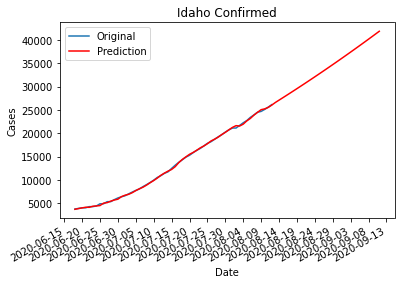

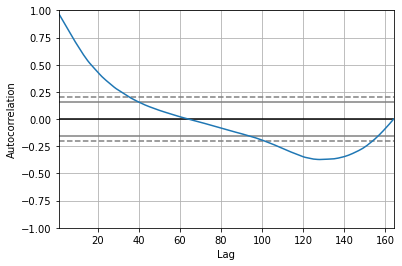

ARIMA(1, 0, 0) MSE=19.260
ARIMA(1, 1, 0) MSE=9.789
ARIMA(1, 1, 1) MSE=8.100
ARIMA(1, 2, 0) MSE=9.881
ARIMA(1, 2, 1) MSE=8.038
ARIMA(1, 2, 2) MSE=7.691
ARIMA(2, 0, 0) MSE=10.271
ARIMA(2, 1, 0) MSE=9.660
ARIMA(2, 1, 1) MSE=8.242
ARIMA(2, 2, 0) MSE=9.292
ARIMA(2, 2, 1) MSE=8.261
ARIMA(2, 2, 2) MSE=8.632
ARIMA(3, 0, 0) MSE=9.811
ARIMA(3, 1, 0) MSE=9.394
ARIMA(3, 1, 1) MSE=8.478
ARIMA(3, 1, 2) MSE=8.058
ARIMA(3, 2, 0) MSE=9.494
ARIMA(4, 1, 0) MSE=9.720
ARIMA(4, 1, 1) MSE=8.742
ARIMA(4, 1, 2) MSE=9.154
ARIMA(4, 2, 0) MSE=9.550
ARIMA(4, 2, 1) MSE=8.586
ARIMA(4, 2, 2) MSE=7.916
ARIMA(5, 0, 0) MSE=9.755
ARIMA(5, 1, 0) MSE=9.776
ARIMA(5, 2, 0) MSE=9.075
ARIMA(5, 2, 1) MSE=8.198
ARIMA(5, 2, 2) MSE=8.183
ARIMA(6, 1, 0) MSE=9.352
ARIMA(6, 2, 0) MSE=6.766
ARIMA(6, 2, 1) MSE=6.992
ARIMA(6, 2, 2) MSE=7.461
ARIMA(7, 1, 0) MSE=6.977
ARIMA(7, 2, 0) MSE=6.952
ARIMA(7, 2, 1) MSE=6.929
ARIMA(7, 2, 2) MSE=7.338
ARIMA(8, 1, 0) MSE=7.134
ARIMA(8, 2, 0) MSE=7.059
ARIMA(8, 2, 1) MSE=7.044
ARIMA(9, 1, 0) MSE=7.16

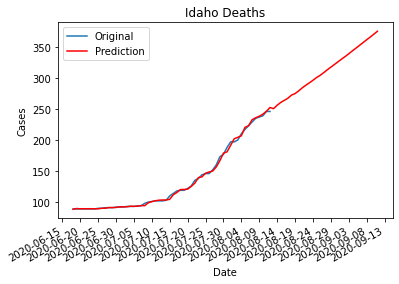

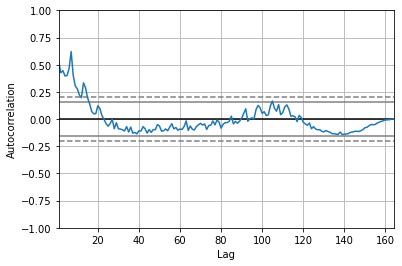

ARIMA(1, 0, 0) MSE=9.790
ARIMA(1, 0, 1) MSE=8.098
ARIMA(1, 1, 0) MSE=9.881
ARIMA(1, 1, 1) MSE=8.039
ARIMA(1, 1, 2) MSE=7.691
ARIMA(1, 2, 0) MSE=20.644
ARIMA(2, 0, 0) MSE=9.659
ARIMA(2, 0, 1) MSE=8.240
ARIMA(2, 1, 0) MSE=9.292
ARIMA(2, 1, 1) MSE=8.262
ARIMA(2, 1, 2) MSE=8.630
ARIMA(2, 2, 0) MSE=15.653
ARIMA(3, 0, 0) MSE=9.392
ARIMA(3, 0, 1) MSE=8.474
ARIMA(3, 0, 2) MSE=8.123
ARIMA(3, 1, 0) MSE=9.494
ARIMA(3, 2, 0) MSE=14.441
ARIMA(4, 0, 0) MSE=9.719
ARIMA(4, 0, 1) MSE=8.753
ARIMA(4, 0, 2) MSE=9.306
ARIMA(4, 1, 0) MSE=9.550
ARIMA(4, 1, 1) MSE=8.586
ARIMA(4, 1, 2) MSE=7.916
ARIMA(4, 2, 0) MSE=14.523
ARIMA(5, 0, 0) MSE=9.775
ARIMA(5, 1, 0) MSE=9.075
ARIMA(5, 1, 1) MSE=8.198
ARIMA(5, 2, 0) MSE=15.110
ARIMA(6, 0, 0) MSE=9.350
ARIMA(6, 1, 0) MSE=6.766
ARIMA(6, 1, 1) MSE=6.992
ARIMA(6, 1, 2) MSE=7.459
ARIMA(6, 2, 0) MSE=9.821
ARIMA(7, 0, 0) MSE=6.976
ARIMA(7, 1, 0) MSE=6.952
ARIMA(7, 1, 1) MSE=6.930
ARIMA(7, 1, 2) MSE=7.341
ARIMA(7, 2, 0) MSE=8.287
ARIMA(7, 2, 2) MSE=7.164
ARIMA(8, 0, 0) MSE=7

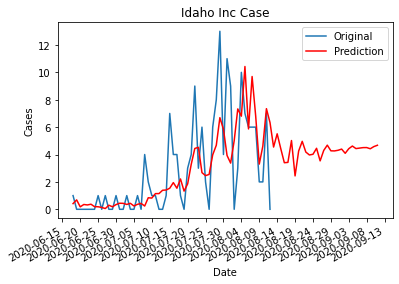

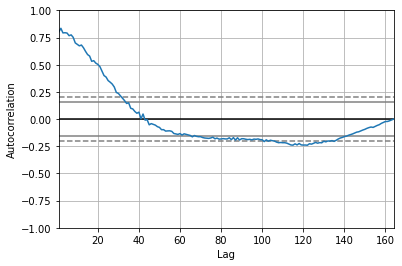

ARIMA(1, 0, 0) MSE=42876.701
ARIMA(1, 1, 0) MSE=28241.925
ARIMA(1, 1, 1) MSE=23841.165
ARIMA(1, 1, 2) MSE=25141.256
ARIMA(1, 2, 0) MSE=62797.620
ARIMA(2, 0, 0) MSE=29600.705
ARIMA(2, 1, 0) MSE=26876.841
ARIMA(2, 1, 1) MSE=25587.429
ARIMA(2, 2, 0) MSE=47421.385
ARIMA(3, 0, 0) MSE=28047.234
ARIMA(3, 1, 0) MSE=27289.050
ARIMA(3, 1, 1) MSE=26986.365
ARIMA(3, 2, 0) MSE=44841.739
ARIMA(4, 0, 0) MSE=28698.854
ARIMA(4, 1, 0) MSE=26418.343
ARIMA(4, 1, 1) MSE=25795.363
ARIMA(4, 2, 0) MSE=40727.225
ARIMA(5, 0, 0) MSE=27659.650
ARIMA(5, 1, 0) MSE=26758.535
ARIMA(5, 1, 1) MSE=29052.298
ARIMA(5, 2, 0) MSE=40340.437
ARIMA(6, 0, 0) MSE=27961.606
ARIMA(6, 1, 0) MSE=26400.614
ARIMA(6, 1, 1) MSE=26510.971
ARIMA(7, 0, 0) MSE=27799.827
ARIMA(7, 1, 0) MSE=26301.120
ARIMA(8, 0, 0) MSE=27844.868
ARIMA(8, 1, 0) MSE=26323.909
ARIMA(9, 0, 0) MSE=28356.418
ARIMA(9, 1, 0) MSE=26586.106
Best ARIMA(1, 1, 1) MSE=23841.165
predicted=53.650955, expected=111.000000
predicted=100.244623, expected=128.000000
predicted=113

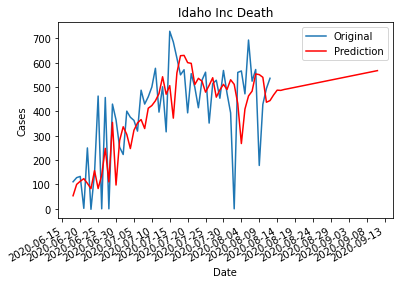

                      Confirmed     Deaths   Inc Case  Inc Death
US                          NaN        NaN        NaN        NaN
Alaska                      NaN        NaN        NaN        NaN
Alabama                     NaN        NaN        NaN        NaN
Arkansas                    NaN        NaN        NaN        NaN
Arizona               (1, 2, 1)  (6, 2, 0)  (6, 1, 0)  (1, 1, 1)
California            (6, 1, 0)  (9, 2, 0)  (9, 1, 0)  (6, 0, 0)
Colorado              (9, 1, 1)  (9, 0, 0)  (2, 1, 2)  (9, 0, 1)
Connecticut           (8, 0, 0)  (2, 2, 1)  (2, 1, 1)  (7, 1, 1)
District of Columbia  (7, 1, 0)  (1, 1, 1)  (1, 0, 1)  (6, 1, 0)
Delaware              (4, 1, 0)  (1, 1, 1)  (1, 0, 1)  (3, 0, 1)
Florida               (1, 1, 0)  (7, 2, 0)  (7, 1, 0)  (1, 0, 0)
Georgia               (8, 2, 1)  (6, 2, 0)  (6, 1, 0)  (8, 1, 1)
Guam                  (5, 1, 1)  (1, 2, 0)  (1, 1, 0)  (5, 0, 1)
Hawaii                (3, 2, 0)  (6, 2, 0)  (6, 1, 0)  (3, 1, 0)
Iowa                  (5,

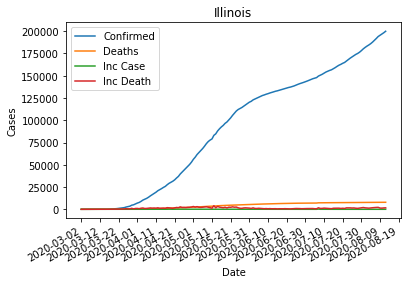

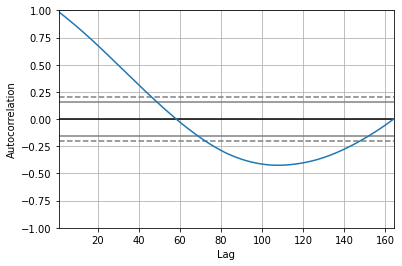

ARIMA(1, 0, 0) MSE=1586121.784
ARIMA(1, 1, 0) MSE=74145.179
ARIMA(1, 1, 1) MSE=74653.118
ARIMA(1, 1, 2) MSE=79248.514
ARIMA(1, 2, 0) MSE=90872.037
ARIMA(1, 2, 1) MSE=79417.235
ARIMA(1, 2, 2) MSE=78611.896
ARIMA(2, 0, 0) MSE=91442.666
ARIMA(2, 1, 0) MSE=87245.897
ARIMA(2, 1, 1) MSE=81288.468
ARIMA(2, 1, 2) MSE=80085.447
ARIMA(2, 2, 0) MSE=91218.615
ARIMA(2, 2, 1) MSE=79101.927
ARIMA(2, 2, 2) MSE=76942.209
ARIMA(3, 0, 0) MSE=101527.698
ARIMA(3, 1, 0) MSE=88477.789
ARIMA(3, 1, 1) MSE=80827.954
ARIMA(3, 1, 2) MSE=78781.388
ARIMA(3, 2, 0) MSE=85993.237
ARIMA(3, 2, 1) MSE=74415.570
ARIMA(4, 0, 0) MSE=105285.835
ARIMA(4, 1, 0) MSE=84844.232
ARIMA(4, 1, 1) MSE=76617.356
ARIMA(4, 1, 2) MSE=78986.004
ARIMA(4, 2, 0) MSE=79196.295
ARIMA(4, 2, 1) MSE=70426.358
ARIMA(4, 2, 2) MSE=74765.076
ARIMA(5, 0, 0) MSE=103462.431
ARIMA(5, 1, 0) MSE=79651.534
ARIMA(5, 1, 1) MSE=73179.867
ARIMA(5, 2, 0) MSE=66469.408
ARIMA(5, 2, 1) MSE=66267.470
ARIMA(5, 2, 2) MSE=65705.198
ARIMA(6, 1, 0) MSE=69237.983
ARIMA(6, 

LinAlgError: SVD did not converge

In [9]:
best_df = pd.DataFrame(index=state_names, columns=["Confirmed","Deaths","Inc Case","Inc Death"])
pred = pd.DataFrame(columns=["location","target","type","quantile","forecast_date","target_end_date","value"])

df_cum_case = pd.read_csv("../Ground Truth/cum_case.csv",index_col="Province_State")
df_cum_death = pd.read_csv("../Ground Truth/cum_death.csv",index_col="Province_State")
df_inc_case = pd.read_csv("../Ground Truth/inc_case.csv",index_col="Province_State")
df_inc_death = pd.read_csv("../Ground Truth/inc_death.csv",index_col="Province_State")

for state in state_names:
    try:
        df = pd.DataFrame(columns=df_cum_case.columns)
        df = df.append(df_cum_case.loc[state],ignore_index=False)
        df.rename({state:"Confirmed"},axis='index',inplace=True)
        df = df.append(df_cum_death.loc[state],ignore_index=False)
        df.rename({state:"Deaths"},axis='index',inplace=True)
        df = df.append(df_inc_death.loc[state],ignore_index=False)
        df.rename({state:"New_Deaths"},axis='index',inplace=True)
        df = df.append(df_inc_case.loc[state],ignore_index=False)
        df.rename({state:"New_Confirmed"},axis='index',inplace=True)
        df.drop(["2020-03-01"],axis=1,inplace=True)
        best_df, pred = combined(state, df, best_df, pred)
        print(best_df)
        print(pred)
        print(state + " prediction done.")
    except:
        print(state + " prediction error.")

In [67]:
pred.to_csv("./GITIDEAS-ARIMA.csv",index=False)
best_df.to_csv("./best_cfg.csv")